### read multiple screening result csv files in one df

In [1]:
import pandas as pd
import glob
import sklearn
from sklearn import preprocessing
import joblib
from rdkit import DataStructs
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import MolFromSmiles,AllChem,Descriptors
from rdkit.Chem import Draw

In [2]:
#read and combine screening result of four models

for i in [1, 2, 3, 4]:
    
    csv_files = glob.glob(f"./*model{i}_screen.csv")
    df_list = [pd.read_csv(filename) for filename in csv_files]

    exec(f"df{i} = pd.concat(df_list, ignore_index=True)")
    

In [3]:
len(df1), len(df2), len(df3), len(df4)

(299441, 243241, 3775, 19859)

In [4]:
df1

,preprocessedSmiles,MOLPORTID,Predicted_result
0,COc1ccc(S(=O)(=O)C(CNS(=O)(=O)c2ccc(OC)c(Cl)c2...,MolPort-008-042-153,0.534
1,COc1ccc(S(=O)(=O)C(CNS(=O)(=O)c2ccc(OC(C)C)cc2...,MolPort-008-042-156,0.503
2,COc1ccc(S(=O)(=O)NCC(c2cccnc2)S(=O)(=O)c2ccc(C...,MolPort-008-042-202,0.577
3,O=S(=O)(CCCc1ccccc1)NCC(c1cccnc1)S(=O)(=O)c1cc...,MolPort-008-042-203,0.555
4,CC(C)Oc1ccc(S(=O)(=O)NCC(c2cccnc2)S(=O)(=O)c2c...,MolPort-008-042-205,0.629
...,...,...,...
299436,O=C(NCCCn1ccnc1)c1cc(-c2ccc3c(c2)OCO3)nc2ccccc12,MolPort-001-545-260,0.659
299437,COc1cccc(-c2cc(C(=O)N3CCN(c4ncccn4)CC3)c3ccccc...,MolPort-001-545-437,0.525
299438,COc1cccc(-c2cc(C(=O)NCc3ccc(S(N)(=O)=O)cc3)c3c...,MolPort-001-545-838,0.521
299439,O=C(Nc1ccc([N+](=O)[O-])cc1)c1cc(-c2ccc3c(c2)O...,MolPort-001-545-885,0.529


In [5]:
# filter with proba more than 0.6
df1 = df1[df1['Predicted_result'] > 0.6]
df2 = df2[df2['Predicted_result'] > 0.6]
df3 = df3[df3['Predicted_result'] > 0.6]
df4 = df4[df4['Predicted_result'] > 0.6]
len(df1), len(df2), len(df3), len(df4)

(72768, 84767, 804, 5629)

In [6]:
# filter with proba more than 0.7
df1 = df1[df1['Predicted_result'] > 0.7]
df2 = df2[df2['Predicted_result'] > 0.7]
df3 = df3[df3['Predicted_result'] > 0.7]
df4 = df4[df4['Predicted_result'] > 0.7]
len(df1), len(df2), len(df3), len(df4)

(12565, 19443, 188, 1449)

In [7]:
#sort by proba
df1 = df1.sort_values(by='Predicted_result', ascending=False)
df2 = df2.sort_values(by='Predicted_result', ascending=False)
df3 = df3.sort_values(by='Predicted_result', ascending=False)
df4 = df4.sort_values(by='Predicted_result', ascending=False)

In [8]:
#get rank for dfs
for i in [1, 2, 3, 4]:
    exec(f"df{i}['rank'] = df{i}['Predicted_result'].rank(ascending=False)")
    exec(f"df{i} = df{i}.sort_values(by='rank')")

In [9]:
# processed rank < 10000 for each model (df1 and 2)
df1 = df1[df1['rank'] < 10000]
df2 = df2[df2['rank'] < 10000]

In [10]:
print (len(df1), len(df2), len(df3), len(df4))

9947 10092 188 1449


In [11]:
dfs = [df1, df2, df3, df4]

for i, df in enumerate(dfs, start=1):
    df['Rank'] = range(1, len(df) + 1)
    df['Model'] = f'Model{i}'
    df['Modelrank'] = df['Model'] + str('_') + df['Rank'].astype(str)
    df.rename(columns={'Predicted_result': f'model{i}_proba'}, inplace=True)


In [12]:
hit_collection = pd.concat([df1, df2, df3, df4])
# Record the best rank for each MOLPORTID, ignoring NaN values
hit_collection['bestrank'] = hit_collection.groupby('MOLPORTID')['Rank'].transform('min')

# Record the model name with the best rank
# Create a temporary DataFrame to store the best model for each MOLPORTID
best_model_df = hit_collection.loc[hit_collection.groupby('MOLPORTID')['Rank'].idxmin()][['MOLPORTID', 'Model']]

# Merge the best model information back to the hit_collection DataFrame
hit_collection = hit_collection.merge(best_model_df, on='MOLPORTID', suffixes=('', '_best'))

# Rename the merged column to 'bestmodel'
hit_collection.rename(columns={'Model_best': 'bestmodel'}, inplace=True)

In [13]:
hit_collection

,preprocessedSmiles,MOLPORTID,model1_proba,rank,Rank,Model,Modelrank,model2_proba,model3_proba,model4_proba,bestrank,bestmodel
0,N#Cc1ccc(N(Cc2ccc(Br)cc2)n2cnnc2)cc1,MolPort-023-276-728,0.999,1.0,1,Model1,Model1_1,NaN,NaN,NaN,1,Model1
1,N#Cc1ccc(N(Cc2ccc(Br)cc2)n2cnnc2)cc1,MolPort-023-276-728,NaN,34.0,34,Model2,Model2_34,0.959,NaN,NaN,1,Model1
2,COc1ccc(S(=O)(=O)NCCCn2ccnc2)cc1C,MolPort-000-121-470,0.998,2.5,2,Model1,Model1_2,NaN,NaN,NaN,2,Model1
3,COc1ccc(S(=O)(=O)NCCCn2ccnc2)cc1C,MolPort-000-121-470,NaN,23.0,23,Model2,Model2_23,0.966,NaN,NaN,2,Model1
4,Cc1cc(S(=O)(=O)N2CCCC(Cn3ccnc3)C2)c(Cl)cc1F,MolPort-046-178-350,0.998,2.5,3,Model1,Model1_3,NaN,NaN,NaN,3,Model1
...,...,...,...,...,...,...,...,...,...,...,...,...
22530,N#Cc1c(N)nc2c(-c3ccc(Cl)cc3)cnn2c1-c1ccccc1,MolPort-005-308-533,NaN,1442.0,1446,Model4,Model4_1446,NaN,NaN,0.701,1446,Model4
22531,N#Cc1c(N)nc2c(-c3ccc(Cl)cc3)cnn2c1-c1ccccc1,MolPort-005-308-533,NaN,1442.0,1446,Model4,Model4_1446,NaN,NaN,0.701,1446,Model4
22532,Cc1c(-c2cnn(C)c2)nc(N)c(C#N)c1-c1cccc(Cl)c1,MolPort-020-216-219,NaN,1442.0,1447,Model4,Model4_1447,NaN,NaN,0.701,1447,Model4
22533,Fc1cccc(Cl)c1C1CC(c2ccc(Br)cc2)=Nc2ncnn21,MolPort-002-264-105,NaN,1442.0,1448,Model4,Model4_1448,NaN,NaN,0.701,1448,Model4


In [14]:
# Filter the DataFrame to keep only rows where Rank equals bestrank
hit_collection_best = hit_collection[hit_collection['Rank'] == hit_collection['bestrank']]
hit_collection_best


,preprocessedSmiles,MOLPORTID,model1_proba,rank,Rank,Model,Modelrank,model2_proba,model3_proba,model4_proba,bestrank,bestmodel
0,N#Cc1ccc(N(Cc2ccc(Br)cc2)n2cnnc2)cc1,MolPort-023-276-728,0.999,1.0,1,Model1,Model1_1,NaN,NaN,NaN,1,Model1
2,COc1ccc(S(=O)(=O)NCCCn2ccnc2)cc1C,MolPort-000-121-470,0.998,2.5,2,Model1,Model1_2,NaN,NaN,NaN,2,Model1
4,Cc1cc(S(=O)(=O)N2CCCC(Cn3ccnc3)C2)c(Cl)cc1F,MolPort-046-178-350,0.998,2.5,3,Model1,Model1_3,NaN,NaN,NaN,3,Model1
5,Cc1cc(S(=O)(=O)N2CCCC(Cn3ccnc3)C2)c(Cl)cc1F,MolPort-046-178-350,NaN,3.0,3,Model2,Model2_3,0.992,NaN,NaN,3,Model1
6,COc1cc(S(=O)(=O)NCCCn2ccnc2)ccc1F,MolPort-000-123-363,0.995,4.5,4,Model1,Model1_4,NaN,NaN,NaN,4,Model1
...,...,...,...,...,...,...,...,...,...,...,...,...
22530,N#Cc1c(N)nc2c(-c3ccc(Cl)cc3)cnn2c1-c1ccccc1,MolPort-005-308-533,NaN,1442.0,1446,Model4,Model4_1446,NaN,NaN,0.701,1446,Model4
22531,N#Cc1c(N)nc2c(-c3ccc(Cl)cc3)cnn2c1-c1ccccc1,MolPort-005-308-533,NaN,1442.0,1446,Model4,Model4_1446,NaN,NaN,0.701,1446,Model4
22532,Cc1c(-c2cnn(C)c2)nc(N)c(C#N)c1-c1cccc(Cl)c1,MolPort-020-216-219,NaN,1442.0,1447,Model4,Model4_1447,NaN,NaN,0.701,1447,Model4
22533,Fc1cccc(Cl)c1C1CC(c2ccc(Br)cc2)=Nc2ncnn21,MolPort-002-264-105,NaN,1442.0,1448,Model4,Model4_1448,NaN,NaN,0.701,1448,Model4


In [15]:
# Drop duplicates based on MOLPORTID, keeping the first occurrence (which will have the best rank due to previous filtering)
hit_collection = hit_collection_best.drop_duplicates(subset='MOLPORTID', keep='first')
hit_collection

,preprocessedSmiles,MOLPORTID,model1_proba,rank,Rank,Model,Modelrank,model2_proba,model3_proba,model4_proba,bestrank,bestmodel
0,N#Cc1ccc(N(Cc2ccc(Br)cc2)n2cnnc2)cc1,MolPort-023-276-728,0.999,1.0,1,Model1,Model1_1,NaN,NaN,NaN,1,Model1
2,COc1ccc(S(=O)(=O)NCCCn2ccnc2)cc1C,MolPort-000-121-470,0.998,2.5,2,Model1,Model1_2,NaN,NaN,NaN,2,Model1
4,Cc1cc(S(=O)(=O)N2CCCC(Cn3ccnc3)C2)c(Cl)cc1F,MolPort-046-178-350,0.998,2.5,3,Model1,Model1_3,NaN,NaN,NaN,3,Model1
6,COc1cc(S(=O)(=O)NCCCn2ccnc2)ccc1F,MolPort-000-123-363,0.995,4.5,4,Model1,Model1_4,NaN,NaN,NaN,4,Model1
8,Cc1cc(Cn2ccnc2)c(C)cc1Cn1ccnc1,MolPort-002-547-583,0.995,4.5,5,Model1,Model1_5,NaN,NaN,NaN,5,Model1
...,...,...,...,...,...,...,...,...,...,...,...,...
22529,Clc1ccc(Cn2ncc3c(Nc4ccc(Cl)cc4)ncnc32)cc1,MolPort-000-437-702,NaN,1442.0,1445,Model4,Model4_1445,NaN,NaN,0.701,1445,Model4
22530,N#Cc1c(N)nc2c(-c3ccc(Cl)cc3)cnn2c1-c1ccccc1,MolPort-005-308-533,NaN,1442.0,1446,Model4,Model4_1446,NaN,NaN,0.701,1446,Model4
22532,Cc1c(-c2cnn(C)c2)nc(N)c(C#N)c1-c1cccc(Cl)c1,MolPort-020-216-219,NaN,1442.0,1447,Model4,Model4_1447,NaN,NaN,0.701,1447,Model4
22533,Fc1cccc(Cl)c1C1CC(c2ccc(Br)cc2)=Nc2ncnn21,MolPort-002-264-105,NaN,1442.0,1448,Model4,Model4_1448,NaN,NaN,0.701,1448,Model4


### calculate similarity with known actives and inactives

In [16]:
#read active and inactive datas
chembl_active = pd.read_csv('/home/sliu/cyp_related_coding/CYP19_inhibitor_screening/datasets/2_preprocessed/chembl_preprocessed_active.csv')
chembl_inactive = pd.read_csv('/home/sliu/cyp_related_coding/CYP19_inhibitor_screening/datasets/2_preprocessed/chembl_preprocessed_inactive.csv')
pubchem_active = pd.read_csv('/home/sliu/cyp_related_coding/CYP19_inhibitor_screening/datasets/2_preprocessed/pubchem_preprocessed_active.csv')
pubchem_inactive = pd.read_csv('/home/sliu/cyp_related_coding/CYP19_inhibitor_screening/datasets/2_preprocessed/pubchem_preprocessed_inactive.csv')

In [17]:
chembl = pd.concat([chembl_active, chembl_inactive])
pubchem = pd.concat([pubchem_active, pubchem_inactive])

In [18]:
pubchem = pubchem.rename(columns={'PUBCHEM_SID': 'id'})
chembl = chembl.rename(columns={'Molecule ChEMBL ID': 'id'})

In [19]:
#used in the next function
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [20]:
def similarity_between(df,top):
    PandasTools.AddMoleculeColumnToFrame(df,'preprocessedSmiles','Molecule')
    
    df_smis = list(df.preprocessedSmiles)
    df_activity = list(df.y_true_label)
    df_fps = [AllChem.GetMorganFingerprintAsBitVect(m,2,nBits=2048) for m in list(df.Molecule)]
    
    def closest_compound(row):
        m = Chem.MolFromSmiles(row.preprocessedSmiles)
        fp = AllChem.GetMorganFingerprintAsBitVect(m,2,nBits=2048)
        s = DataStructs.BulkTanimotoSimilarity(fp, df_fps)
        max_s = max(s)
        max_index = s.index(max_s)
        return [max_s,df_smis[max_index],df_activity[max_index]]
    
    name = get_df_name(df)
    top['closest_compound_inf'] = top.apply(lambda row:closest_compound(row),axis=1)
    top[['similairty_'+name,'closest_'+name+'_smiles','closest_'+name+'_activity']] = top.closest_compound_inf.to_list()
    del top['closest_compound_inf']

In [21]:
pd.options.mode.chained_assignment = None

In [22]:
similarity_between(chembl,hit_collection)
similarity_between(pubchem,hit_collection)

In [23]:
# keep with similarity less than 0.7
hit_collection = hit_collection[(hit_collection['similairty_chembl'] < 0.7) & (hit_collection['similairty_pubchem'] < 0.7)]
hit_collection

,preprocessedSmiles,MOLPORTID,model1_proba,rank,Rank,Model,Modelrank,model2_proba,model3_proba,model4_proba,bestrank,bestmodel,similairty_chembl,closest_chembl_smiles,closest_chembl_activity,similairty_pubchem,closest_pubchem_smiles,closest_pubchem_activity
8,Cc1cc(Cn2ccnc2)c(C)cc1Cn1ccnc1,MolPort-002-547-583,0.995,4.5,5,Model1,Model1_5,NaN,NaN,NaN,5,Model1,0.45,c1ccc(Oc2ccccc2Cn2ccnc2)cc1,1,0.36,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0
30,Cc1cc2oc(=O)cc(Cn3ccnc3)c2cc1C,MolPort-002-644-642,0.985,16.0,15,Model1,Model1_15,NaN,NaN,NaN,15,Model1,0.653061,COc1ccc2c(Cn3ccnc3)cc(=O)oc2c1,1,0.35,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0
45,O=[N+]([O-])c1cccc(S(=O)(=O)NCCCn2ccnc2)c1,MolPort-002-266-557,0.982,21.0,21,Model1,Model1_21,NaN,NaN,NaN,21,Model1,0.596491,O=S(=O)(NCCCn1ccnc1)c1ccc2c(c1)OCCO2,1,0.617021,O=[N+]([O-])c1cccc(S(=O)(=O)NCCNS(=O)(=O)c2ccc...,0.0
49,O=c1cc(Cn2ccnc2)c2cc3c(cc2o1)CCC3,MolPort-002-645-393,0.980,23.0,23,Model1,Model1_23,NaN,NaN,NaN,23,Model1,0.584906,COc1ccc2c(Cn3ccnc3)cc(=O)oc2c1,1,0.272727,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0
51,N#Cc1ccc(C(=O)N2CC(n3ccnc3)C2)cc1,MolPort-044-359-245,0.979,24.0,24,Model1,Model1_24,NaN,NaN,NaN,24,Model1,0.387755,N#Cc1ccc(C(c2ccc(C#N)cc2)n2ccnc2)cc1,1,0.283019,N#Cc1ccc(C(c2ccc(C#N)cc2)n2cncn2)cc1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22529,Clc1ccc(Cn2ncc3c(Nc4ccc(Cl)cc4)ncnc32)cc1,MolPort-000-437-702,NaN,1442.0,1445,Model4,Model4_1445,NaN,NaN,0.701,1445,Model4,0.254545,S=C(NCc1cccc(CNC(=S)Nc2ccc(Cl)cc2)c1)Nc1ccc(Cl...,0,0.333333,Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1,1.0
22530,N#Cc1c(N)nc2c(-c3ccc(Cl)cc3)cnn2c1-c1ccccc1,MolPort-005-308-533,NaN,1442.0,1446,Model4,Model4_1446,NaN,NaN,0.701,1446,Model4,0.261538,N#Cc1ccc(Cn2cncn2)c(-c2ccccc2)c1,1,0.253968,O=C(O)Cc1sc(-c2ccccc2)nc1-c1ccc(Cl)cc1,0.0
22532,Cc1c(-c2cnn(C)c2)nc(N)c(C#N)c1-c1cccc(Cl)c1,MolPort-020-216-219,NaN,1442.0,1447,Model4,Model4_1447,NaN,NaN,0.701,1447,Model4,0.3,N#Cc1ccc(Cn2cncn2)cc1-c1cccc(Cl)c1,1,0.3,Clc1cccc(-c2cc(Cl)cc(Cl)c2)c1,0.0
22533,Fc1cccc(Cl)c1C1CC(c2ccc(Br)cc2)=Nc2ncnn21,MolPort-002-264-105,NaN,1442.0,1448,Model4,Model4_1448,NaN,NaN,0.701,1448,Model4,0.212121,Brc1ccc(C2CCCc3cncn32)cc1,1,0.203704,Clc1cccc(-c2cc(Cl)cc(Cl)c2)c1,0.0


In [24]:
# number of rotatable bonds less than 8
hit_collection['num_rotatable_bonds'] = hit_collection['preprocessedSmiles'].apply(lambda x: Descriptors.NumRotatableBonds(Chem.MolFromSmiles(x)))
hit_collection = hit_collection[hit_collection['num_rotatable_bonds'] < 8]
hit_collection

,preprocessedSmiles,MOLPORTID,model1_proba,rank,Rank,Model,Modelrank,model2_proba,model3_proba,model4_proba,bestrank,bestmodel,similairty_chembl,closest_chembl_smiles,closest_chembl_activity,similairty_pubchem,closest_pubchem_smiles,closest_pubchem_activity,num_rotatable_bonds
8,Cc1cc(Cn2ccnc2)c(C)cc1Cn1ccnc1,MolPort-002-547-583,0.995,4.5,5,Model1,Model1_5,NaN,NaN,NaN,5,Model1,0.45,c1ccc(Oc2ccccc2Cn2ccnc2)cc1,1,0.36,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,4
30,Cc1cc2oc(=O)cc(Cn3ccnc3)c2cc1C,MolPort-002-644-642,0.985,16.0,15,Model1,Model1_15,NaN,NaN,NaN,15,Model1,0.653061,COc1ccc2c(Cn3ccnc3)cc(=O)oc2c1,1,0.35,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,2
45,O=[N+]([O-])c1cccc(S(=O)(=O)NCCCn2ccnc2)c1,MolPort-002-266-557,0.982,21.0,21,Model1,Model1_21,NaN,NaN,NaN,21,Model1,0.596491,O=S(=O)(NCCCn1ccnc1)c1ccc2c(c1)OCCO2,1,0.617021,O=[N+]([O-])c1cccc(S(=O)(=O)NCCNS(=O)(=O)c2ccc...,0.0,7
49,O=c1cc(Cn2ccnc2)c2cc3c(cc2o1)CCC3,MolPort-002-645-393,0.980,23.0,23,Model1,Model1_23,NaN,NaN,NaN,23,Model1,0.584906,COc1ccc2c(Cn3ccnc3)cc(=O)oc2c1,1,0.272727,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,2
51,N#Cc1ccc(C(=O)N2CC(n3ccnc3)C2)cc1,MolPort-044-359-245,0.979,24.0,24,Model1,Model1_24,NaN,NaN,NaN,24,Model1,0.387755,N#Cc1ccc(C(c2ccc(C#N)cc2)n2ccnc2)cc1,1,0.283019,N#Cc1ccc(C(c2ccc(C#N)cc2)n2cncn2)cc1,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22529,Clc1ccc(Cn2ncc3c(Nc4ccc(Cl)cc4)ncnc32)cc1,MolPort-000-437-702,NaN,1442.0,1445,Model4,Model4_1445,NaN,NaN,0.701,1445,Model4,0.254545,S=C(NCc1cccc(CNC(=S)Nc2ccc(Cl)cc2)c1)Nc1ccc(Cl...,0,0.333333,Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1,1.0,4
22530,N#Cc1c(N)nc2c(-c3ccc(Cl)cc3)cnn2c1-c1ccccc1,MolPort-005-308-533,NaN,1442.0,1446,Model4,Model4_1446,NaN,NaN,0.701,1446,Model4,0.261538,N#Cc1ccc(Cn2cncn2)c(-c2ccccc2)c1,1,0.253968,O=C(O)Cc1sc(-c2ccccc2)nc1-c1ccc(Cl)cc1,0.0,2
22532,Cc1c(-c2cnn(C)c2)nc(N)c(C#N)c1-c1cccc(Cl)c1,MolPort-020-216-219,NaN,1442.0,1447,Model4,Model4_1447,NaN,NaN,0.701,1447,Model4,0.3,N#Cc1ccc(Cn2cncn2)cc1-c1cccc(Cl)c1,1,0.3,Clc1cccc(-c2cc(Cl)cc(Cl)c2)c1,0.0,2
22533,Fc1cccc(Cl)c1C1CC(c2ccc(Br)cc2)=Nc2ncnn21,MolPort-002-264-105,NaN,1442.0,1448,Model4,Model4_1448,NaN,NaN,0.701,1448,Model4,0.212121,Brc1ccc(C2CCCc3cncn32)cc1,1,0.203704,Clc1cccc(-c2cc(Cl)cc(Cl)c2)c1,0.0,2


In [25]:
# add mol column
PandasTools.AddMoleculeColumnToFrame(hit_collection,'preprocessedSmiles','mol')

In [26]:
substructure_list = ['[CH2][CH2][CH2]', 'Br', 'I', '[N+](=O)[O-]', '[NH2]']

hit_collection['keep'] = False
for smarts in substructure_list:
    substructure = Chem.MolFromSmarts(smarts)
    # Update the 'keep' column if the molecule matches the current substructure
    hit_collection['keep'] |= hit_collection['mol'].apply(lambda x: x.HasSubstructMatch(substructure))
# Filter the DataFrame to keep only rows where 'keep' is False
hit_collection = hit_collection[~hit_collection['keep']]

print(len(hit_collection))


11768


In [27]:
# add PAINS filter
pains_smarts = ["[#6]=[#6]~[#6]=,#[#7&R0,#8,#16]", "[#6,#7,#8,#15,#16]1~[#6,#7,#8,#15,#16]~[#7,#8,#15,#16]~1","[*]1~[*]~[#6](=[#8])~[#7,#8]~1","[#6]1~[#7,#8,#15,#16]~[#7,#8,#15,#16]~[#6,#7,#8,#15,#16]~1","[*]~[#8]~[#8]~[*]","[*]~[#6](=[#8])[#16]~[*]","[#6]1~[#6]([#8])~[#16]~[#6]~[#6]~1","[#7]1~[#6](=[#8])~[#7]~[#7]~[#7]~[#6]~1","[#6]1(=[#7,#8,#16])~[#6]=,:[#6]~[#6](=[#7,#8,#16])~[*]~[*]~1"
,"[#6]1~[#6]~[#6]~[#8]~[#15](=[#8])(~[#7])~[#7]~1","[#6]1~[#6](=[#8])~[#7]~[#16]~[#6]~1","[#8]=[#6]1~[#7]=,:[#6]2~[#7]~[#7]=,:[#6]~[#7]=,:[#6]~2[#6](=[#8])~[#7]~1","[#6]1(=[#7,#8,#16])~[#6](=[#7,#8,#16])~[*]=,:[*]~[*]=,:[*]~1","[#6](=[#7,#8,#15,#16])~[#6](=[#8,#16])~[#7,#8,#15,#16]","[#6](=[#16])~[#7,#8,#15,#16]","[#6](=[#7,#8,#15,#16])~[#7&+]=[#6]","[$([#6,#7,#15]1=,#[#6,#7,#15]~[#6]~1),$([#6,#7,#15]1=,#[#6,#7,#15]~[#6]~[#6]~1)]","[#6]12~[#6](~[#6]~1)~[#6]~2","[$([#6&R]=[#6&R0]),$([#7&R]=[#7&R0])]","[#6]~[#6](=[#7,#8,#16])~[#6](=[#7,#8,#16])~[#6]","[#6](=[#7,#8,#15,#16])~[#8,#16]~[#6](=[#7,#8,#15,#16])"
]

hit_collection['keep'] = False
for smarts in pains_smarts:
    substructure = Chem.MolFromSmarts(smarts)

    # Update the 'keep' column if the molecule matches the current substructure
    hit_collection['keep'] |= hit_collection['mol'].apply(lambda x: x.HasSubstructMatch(substructure))
# Filter the DataFrame to keep only rows where 'keep' is False
hit_collection = hit_collection[~hit_collection['keep']]

print(len(hit_collection))

11527


,preprocessedSmiles,MOLPORTID,model1_proba,rank,Rank,Model,Modelrank,model2_proba,model3_proba,model4_proba,...,bestmodel,similairty_chembl,closest_chembl_smiles,closest_chembl_activity,similairty_pubchem,closest_pubchem_smiles,closest_pubchem_activity,num_rotatable_bonds,mol,keep
130,O=C(c1ccc(Cn2ccnc2)cc1)N1CC(n2nccn2)C1,MolPort-044-874-397,0.955,71.0,71,Model1,Model1_71,NaN,NaN,NaN,...,Model1,0.530612,O=C(c1ccccc1)c1ccc(Cn2ccnc2)cc1,1,0.307692,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,4,,True
167,O=C(c1ccc(Cn2ccnc2)cc1)N1CCC(n2nccn2)CC1,MolPort-046-065-219,0.951,91.0,96,Model1,Model1_96,NaN,NaN,NaN,...,Model1,0.509804,O=C(c1ccccc1)c1ccc(Cn2ccnc2)cc1,1,0.298507,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,4,,True
194,O=C(Cn1nc2ccccc2n1)N1CCC(Cn2ccnc2)CC1,MolPort-044-681-196,0.948,111.5,113,Model1,Model1_113,NaN,NaN,NaN,...,Model1,0.42029,COC(=O)c1ccccc1S(=O)(=O)N1CCCC(Cn2ccnc2)C1,1,0.298507,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,4,,True
348,CC(C)(C)c1nc2ccccc2n1C1CN(C(=O)c2ccc(Cn3ccnc3)...,MolPort-047-356-252,0.933,216.5,216,Model1,Model1_216,NaN,NaN,NaN,...,Model1,0.459016,O=C(c1ccccc1)c1ccc(Cn2ccnc2)cc1,1,0.337838,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,4,,True
527,Cc1cc2nc(CNC(C)Cn3ccnc3)[nH]c2cc1C,MolPort-019-799-113,0.920,328.0,334,Model1,Model1_334,NaN,NaN,NaN,...,Model1,0.33871,Cc1cc(C)c(S(=O)(=O)NCCCn2ccnc2)cc1C,1,0.264706,Clc1ccc(COC(Cn2ccnc2)c2ccc(Cl)cc2Cl)c(Cl)c1,1.0,5,,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22480,Cc1nn(CCO)c(C)c1-n1ccnc1-c1c(F)cccc1Cl,MolPort-047-386-250,NaN,1387.5,1394,Model4,Model4_1394,NaN,NaN,0.704,...,Model4,0.222222,Cc1nn(-c2cncc(C(C)(C)O)c2)c2cccc(F)c12,0,0.258824,Cc1onc(-c2c(F)cccc2Cl)c1C(=O)NC1C(=O)N2C1SC(C)...,0.0,4,,True
22487,OCC(O)Cn1cnc(-c2ccccc2)c1-c1ccc(Cl)cc1Cl,MolPort-016-592-061,NaN,1405.0,1402,Model4,Model4_1402,NaN,NaN,0.703,...,Model4,0.313433,Clc1ccc(CC(Cc2ccc(-c3ccccc3)cc2)n2ccnc2)c(Cl)c1,0,0.311475,Cn1c(=O)c2c(ncn2CC(O)CO)n(C)c1=O,0.0,5,,True
22511,CCc1nccn1S(=O)(=O)c1cccc(Cl)c1Cl,MolPort-001-900-565,NaN,1425.0,1427,Model4,Model4_1427,NaN,NaN,0.702,...,Model4,0.246377,CCOc1ccc(S(=O)(=O)NCCCn2ccnc2)c2ccccc12,1,0.277778,CCN(CC)Cc1nccn1-c1ccc([N+](=O)[O-])cc1C(=O)c1c...,0.0,3,,True
22522,CC(=NO)c1nnn(-c2cc(C(F)(F)F)ccc2Cl)c1C,MolPort-002-894-270,NaN,1442.0,1438,Model4,Model4_1438,NaN,NaN,0.701,...,Model4,0.217391,Cc1nn(-c2cncc(C(C)(O)C(F)(F)F)c2)c2ccccc12,0,0.246575,CCCCN(CCCC)CCC(O)c1cc2c(Cl)cc(Cl)cc2c2cc(C(F)(...,0.0,2,,True

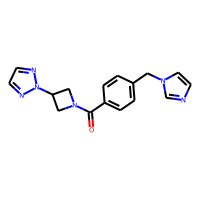
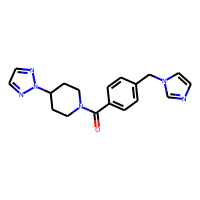
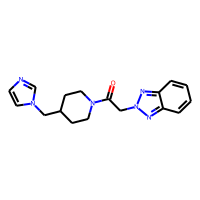
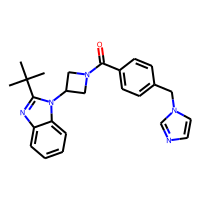
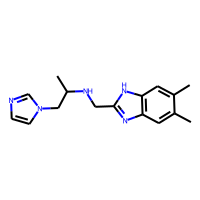
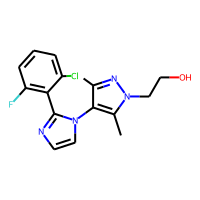
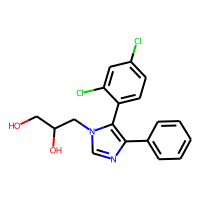
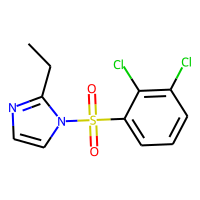
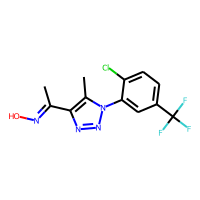
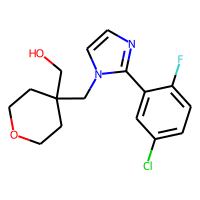

In [28]:
# make sure the N (that contributes lone pair)'s neighbour atom C/N are not substituted, to avoid steric hindrance
# filter the N's neighbour atom C/N are substituted, save seperately as df_StericHindrance  

#convert smiles to mol
#df['mol'] = df['preprocessedSmiles'].apply(lambda x: Chem.MolFromSmiles(x))
df = hit_collection 
substructure_list = ['[c]1(*)[nX2][n,c][n][c]1', '[c]1[nX2][n,c](*)[n][c]1']

df['keep'] = False
for smarts in substructure_list:
    substructure = Chem.MolFromSmarts(smarts)
    # Update the 'keep' column if the molecule matches the current substructure
    df['keep'] |= df['mol'].apply(lambda x: x.HasSubstructMatch(substructure))
df_StericHindrance = df[df['keep']]
df_StericHindrance

In [29]:
# from the df_StericHindrance, recover the mols that has the N's neighbour atom C/N are not substituted ring, and fusion rings of imidazole and pyridine 

substructure_list = ['[c]1[nX2][nX2,cX1]nc1', 'n1c2ncccn2cc1', 'n1c2cnccn2cc1', 'n1c2ccncn2cc1', 'n1c2cccnn2cc1']
df_StericHindrance['recover'] = False

for smarts in substructure_list:
    substructure = Chem.MolFromSmarts(smarts)
    # Update the 'keep' column if the molecule matches the current substructure
    df_StericHindrance['recover'] |= df_StericHindrance['mol'].apply(lambda x: x.HasSubstructMatch(substructure))

df_recover = df_StericHindrance[df_StericHindrance['recover']]

,preprocessedSmiles,MOLPORTID,model1_proba,rank,Rank,Model,Modelrank,model2_proba,model3_proba,model4_proba,...,similairty_chembl,closest_chembl_smiles,closest_chembl_activity,similairty_pubchem,closest_pubchem_smiles,closest_pubchem_activity,num_rotatable_bonds,mol,keep,recover
6092,O=C(Cn1ccnc1)N1CCC(Cn2cc(-c3ccccc3)nn2)CC1,MolPort-005-003-756,0.770,5047.5,5014,Model1,Model1_5014,NaN,NaN,NaN,...,0.363636,O=C(c1ccc(-c2ccccc2)cc1)c1ccccc1Cn1ccnc1,1,0.287671,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,5,,True,True
6556,O=C(Cn1ccnc1)N1CCC(Cn2cc(-c3ccsc3)nn2)CC1,MolPort-047-489-726,0.765,5401.0,5423,Model1,Model1_5423,NaN,NaN,NaN,...,0.303797,O=C(Cc1ccc(F)cc1)N1CCOC(Cn2ccnc2)C1,1,0.242424,O=[PH](=O)(O)C(O)(Cn1ccnc1)[PH](=O)(=O)O,0.0,5,,True,True
6861,CCC(Cn1ccnc1)NCc1c(-c2ccccc2)nc2ncccn12,MolPort-045-944-148,0.761,5668.0,5699,Model1,Model1_5699,NaN,NaN,NaN,...,0.333333,O=C(NCc1ccccc1)OC(Cn1ccnc1)c1ccccc1,1,0.278689,c1ccc(-c2ccc(C(c3ccccc3)n3ccnc3)cc2)cc1,1.0,7,,True,True
6886,O=C(c1nnn(-c2ccccc2F)c1-c1ccncc1)n1ccnc1,MolPort-038-941-668,0.760,5737.0,5724,Model1,Model1_5724,NaN,NaN,NaN,...,0.268657,Fc1ccccc1CN(Cc1ccc(-c2ccccc2)cc1)n1ccnc1,1,0.233333,c1ccc(-c2ccc(C(c3ccccc3)n3ccnc3)cc2)cc1,1.0,3,,True,True
7696,O=C(c1ccc(Cn2ccnc2)cc1)N1CC(n2cc(-c3ccccc3)nn2)C1,MolPort-046-064-372,0.750,6432.0,6443,Model1,Model1_6443,NaN,NaN,NaN,...,0.508772,O=C(c1ccccc1)c1ccc(Cn2ccnc2)cc1,1,0.315068,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,5,,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22333,Cc1ccc(-n2cc(C(=O)c3ccc(F)cc3)nn2)cc1Cl,MolPort-002-852-088,NaN,1250.0,1242,Model4,Model4_1242,NaN,NaN,0.713,...,0.246914,COc1cc2c(cc1OC)CN(S(=O)(=O)c1ccc(-n3cc(COc4ccc...,0,0.278689,Cc1cc(CC(=O)O)n(C)c1C(=O)c1ccc(Cl)cc1,0.0,3,,True,True
22394,N#Cc1cccc(-c2cn(Cc3c(F)cccc3F)nn2)c1,MolPort-027-870-718,NaN,1308.0,1302,Model4,Model4_1302,NaN,NaN,0.709,...,0.530612,N#Cc1ccc(Cn2cc(-c3ccccc3)nn2)cc1,0,0.233766,CC(C)(O)c1cnn2c(-c3ccc(F)c(-c4c(F)cccc4C#N)c3)...,1.0,3,,True,True
22425,Cc1ccc(C(CCO)n2cc(-c3cccc(C#N)c3)nn2)cc1,MolPort-027-887-915,NaN,1326.0,1334,Model4,Model4_1334,NaN,NaN,0.708,...,0.45614,N#Cc1ccc(C(c2ccc(C#N)cc2)n2cc(-c3ccccc3)nn2)cc1,0,0.241935,N#Cc1ccc(C(c2ccc(C#N)cc2)n2cncn2)cc1,1.0,5,,True,True
22454,Cc1ccc2c(c1)nnn2CNc1ccc(Cl)c(Cl)c1,MolPort-002-319-647,NaN,1372.5,1366,Model4,Model4_1366,NaN,NaN,0.705,...,0.227273,Cc1ccc(-n2c(Cn3ccnc3)cc3ccc(Cl)cc32)cc1,1,0.220339,Cc1cc(Nc2ccccc2C(=O)O)ccc1Cl,0.0,3,,True,True

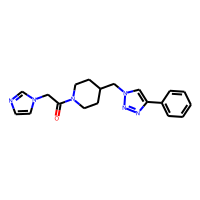
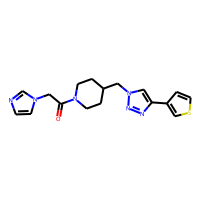
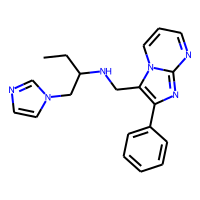
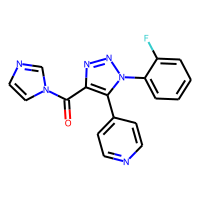
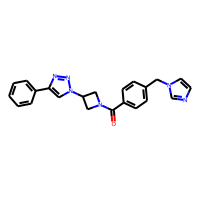
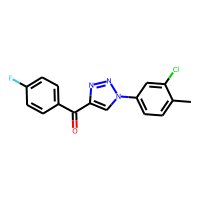
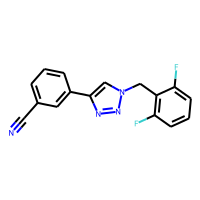
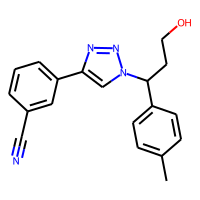
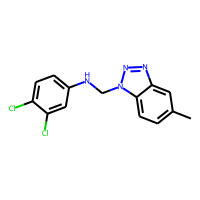
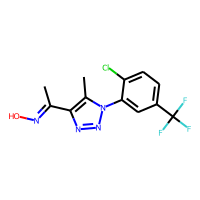

In [30]:
df_recover

,preprocessedSmiles,MOLPORTID,model1_proba,rank,Rank,Model,Modelrank,model2_proba,model3_proba,model4_proba,...,similairty_chembl,closest_chembl_smiles,closest_chembl_activity,similairty_pubchem,closest_pubchem_smiles,closest_pubchem_activity,num_rotatable_bonds,mol,keep,recover
6092,O=C(Cn1ccnc1)N1CCC(Cn2cc(-c3ccccc3)nn2)CC1,MolPort-005-003-756,0.770,5047.5,5014,Model1,Model1_5014,NaN,NaN,NaN,...,0.363636,O=C(c1ccc(-c2ccccc2)cc1)c1ccccc1Cn1ccnc1,1,0.287671,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,5,,True,True
6556,O=C(Cn1ccnc1)N1CCC(Cn2cc(-c3ccsc3)nn2)CC1,MolPort-047-489-726,0.765,5401.0,5423,Model1,Model1_5423,NaN,NaN,NaN,...,0.303797,O=C(Cc1ccc(F)cc1)N1CCOC(Cn2ccnc2)C1,1,0.242424,O=[PH](=O)(O)C(O)(Cn1ccnc1)[PH](=O)(=O)O,0.0,5,,True,True
6861,CCC(Cn1ccnc1)NCc1c(-c2ccccc2)nc2ncccn12,MolPort-045-944-148,0.761,5668.0,5699,Model1,Model1_5699,NaN,NaN,NaN,...,0.333333,O=C(NCc1ccccc1)OC(Cn1ccnc1)c1ccccc1,1,0.278689,c1ccc(-c2ccc(C(c3ccccc3)n3ccnc3)cc2)cc1,1.0,7,,True,True
6886,O=C(c1nnn(-c2ccccc2F)c1-c1ccncc1)n1ccnc1,MolPort-038-941-668,0.760,5737.0,5724,Model1,Model1_5724,NaN,NaN,NaN,...,0.268657,Fc1ccccc1CN(Cc1ccc(-c2ccccc2)cc1)n1ccnc1,1,0.233333,c1ccc(-c2ccc(C(c3ccccc3)n3ccnc3)cc2)cc1,1.0,3,,True,True
7696,O=C(c1ccc(Cn2ccnc2)cc1)N1CC(n2cc(-c3ccccc3)nn2)C1,MolPort-046-064-372,0.750,6432.0,6443,Model1,Model1_6443,NaN,NaN,NaN,...,0.508772,O=C(c1ccccc1)c1ccc(Cn2ccnc2)cc1,1,0.315068,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,5,,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22333,Cc1ccc(-n2cc(C(=O)c3ccc(F)cc3)nn2)cc1Cl,MolPort-002-852-088,NaN,1250.0,1242,Model4,Model4_1242,NaN,NaN,0.713,...,0.246914,COc1cc2c(cc1OC)CN(S(=O)(=O)c1ccc(-n3cc(COc4ccc...,0,0.278689,Cc1cc(CC(=O)O)n(C)c1C(=O)c1ccc(Cl)cc1,0.0,3,,True,True
22394,N#Cc1cccc(-c2cn(Cc3c(F)cccc3F)nn2)c1,MolPort-027-870-718,NaN,1308.0,1302,Model4,Model4_1302,NaN,NaN,0.709,...,0.530612,N#Cc1ccc(Cn2cc(-c3ccccc3)nn2)cc1,0,0.233766,CC(C)(O)c1cnn2c(-c3ccc(F)c(-c4c(F)cccc4C#N)c3)...,1.0,3,,True,True
22425,Cc1ccc(C(CCO)n2cc(-c3cccc(C#N)c3)nn2)cc1,MolPort-027-887-915,NaN,1326.0,1334,Model4,Model4_1334,NaN,NaN,0.708,...,0.45614,N#Cc1ccc(C(c2ccc(C#N)cc2)n2cc(-c3ccccc3)nn2)cc1,0,0.241935,N#Cc1ccc(C(c2ccc(C#N)cc2)n2cncn2)cc1,1.0,5,,True,True
22454,Cc1ccc2c(c1)nnn2CNc1ccc(Cl)c(Cl)c1,MolPort-002-319-647,NaN,1372.5,1366,Model4,Model4_1366,NaN,NaN,0.705,...,0.227273,Cc1ccc(-n2c(Cn3ccnc3)cc3ccc(Cl)cc32)cc1,1,0.220339,Cc1cc(Nc2ccccc2C(=O)O)ccc1Cl,0.0,3,,True,True

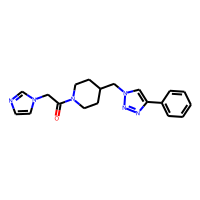
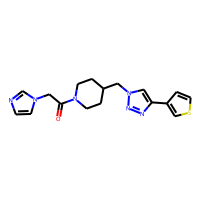
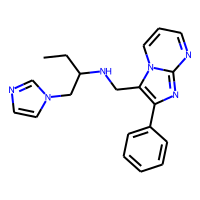
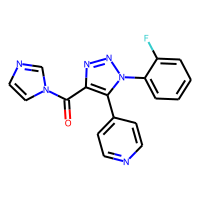
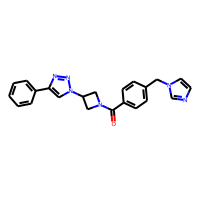
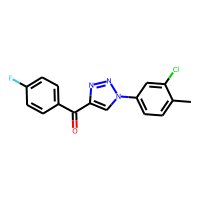
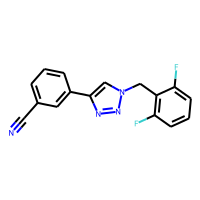
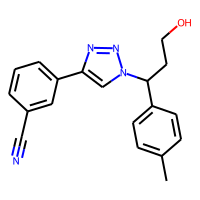
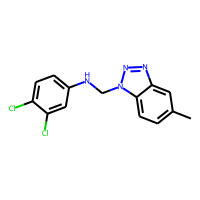
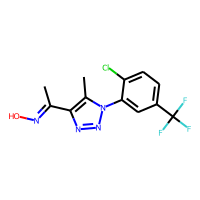

In [31]:
df_recover

In [32]:
# df_final = df - df_StericHindrance + df_recover
df_final = df[~df['MOLPORTID'].isin(df_StericHindrance['MOLPORTID'])]
df_final = pd.concat([df_final, df_recover]).drop_duplicates(keep=False)

,preprocessedSmiles,MOLPORTID,model1_proba,rank,Rank,Model,Modelrank,model2_proba,model3_proba,model4_proba,...,similairty_chembl,closest_chembl_smiles,closest_chembl_activity,similairty_pubchem,closest_pubchem_smiles,closest_pubchem_activity,num_rotatable_bonds,mol,keep,recover
8,Cc1cc(Cn2ccnc2)c(C)cc1Cn1ccnc1,MolPort-002-547-583,0.995,4.5,5,Model1,Model1_5,NaN,NaN,NaN,...,0.45,c1ccc(Oc2ccccc2Cn2ccnc2)cc1,1,0.36,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,4,,False,NaN
30,Cc1cc2oc(=O)cc(Cn3ccnc3)c2cc1C,MolPort-002-644-642,0.985,16.0,15,Model1,Model1_15,NaN,NaN,NaN,...,0.653061,COc1ccc2c(Cn3ccnc3)cc(=O)oc2c1,1,0.35,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,2,,False,NaN
51,N#Cc1ccc(C(=O)N2CC(n3ccnc3)C2)cc1,MolPort-044-359-245,0.979,24.0,24,Model1,Model1_24,NaN,NaN,NaN,...,0.387755,N#Cc1ccc(C(c2ccc(C#N)cc2)n2ccnc2)cc1,1,0.283019,N#Cc1ccc(C(c2ccc(C#N)cc2)n2cncn2)cc1,1.0,2,,False,NaN
52,Cc1cc2oc(=O)cc(Cn3ccnc3)c2cc1Cl,MolPort-002-647-815,0.977,25.0,25,Model1,Model1_25,NaN,NaN,NaN,...,0.603774,COc1ccc2c(Cn3ccnc3)cc(=O)oc2c1,1,0.307692,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,2,,False,NaN
55,Cc1cc2oc(=O)cc(Cn3ccnc3)c2cc1O,MolPort-002-531-039,0.975,26.5,27,Model1,Model1_27,NaN,NaN,NaN,...,0.603774,COc1ccc2c(Cn3ccnc3)cc(=O)oc2c1,1,0.328125,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,2,,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22333,Cc1ccc(-n2cc(C(=O)c3ccc(F)cc3)nn2)cc1Cl,MolPort-002-852-088,NaN,1250.0,1242,Model4,Model4_1242,NaN,NaN,0.713,...,0.246914,COc1cc2c(cc1OC)CN(S(=O)(=O)c1ccc(-n3cc(COc4ccc...,0,0.278689,Cc1cc(CC(=O)O)n(C)c1C(=O)c1ccc(Cl)cc1,0.0,3,,True,True
22394,N#Cc1cccc(-c2cn(Cc3c(F)cccc3F)nn2)c1,MolPort-027-870-718,NaN,1308.0,1302,Model4,Model4_1302,NaN,NaN,0.709,...,0.530612,N#Cc1ccc(Cn2cc(-c3ccccc3)nn2)cc1,0,0.233766,CC(C)(O)c1cnn2c(-c3ccc(F)c(-c4c(F)cccc4C#N)c3)...,1.0,3,,True,True
22425,Cc1ccc(C(CCO)n2cc(-c3cccc(C#N)c3)nn2)cc1,MolPort-027-887-915,NaN,1326.0,1334,Model4,Model4_1334,NaN,NaN,0.708,...,0.45614,N#Cc1ccc(C(c2ccc(C#N)cc2)n2cc(-c3ccccc3)nn2)cc1,0,0.241935,N#Cc1ccc(C(c2ccc(C#N)cc2)n2cncn2)cc1,1.0,5,,True,True
22454,Cc1ccc2c(c1)nnn2CNc1ccc(Cl)c(Cl)c1,MolPort-002-319-647,NaN,1372.5,1366,Model4,Model4_1366,NaN,NaN,0.705,...,0.227273,Cc1ccc(-n2c(Cn3ccnc3)cc3ccc(Cl)cc32)cc1,1,0.220339,Cc1cc(Nc2ccccc2C(=O)O)ccc1Cl,0.0,3,,True,True

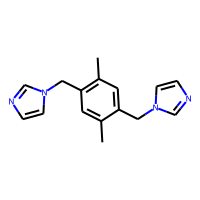
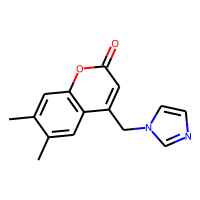
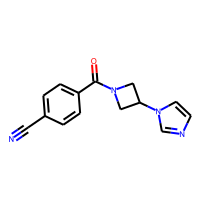
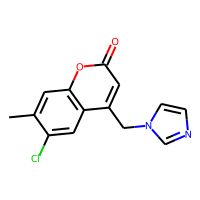
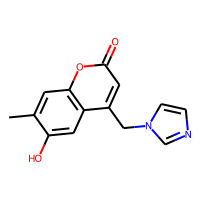
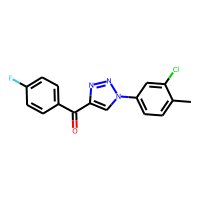
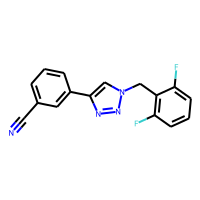
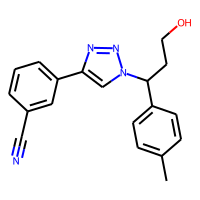
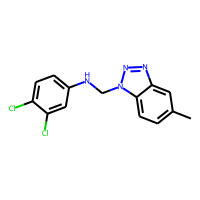
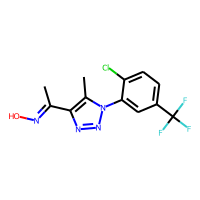

In [33]:
df_final

In [34]:
df_final.drop(columns=['keep', 'recover'], inplace=True)

## Assigning Manually Decided Labels to df_final

In [35]:
### assign the manually labeled 'selection' column to the final dataframe
## read the file 0
df0 = pd.read_csv('/home/sliu/cyp_related_coding/CYP19_inhibitor_screening/old/df_final_0.txt', sep='\t')
df0 = df0[['MOLPORTID', 'selection','cluster_id']]
df0


,MOLPORTID,selection,cluster_id
0,MolPort-051-469-385,<NL>,3274.0
1,MolPort-002-896-346,<NL>0,1084.0
2,MolPort-020-201-972,<NL>0,2179.0
3,MolPort-027-870-821,0,0.0
4,MolPort-029-894-966,0,0.0
...,...,...,...
3475,MolPort-003-043-139,1,149.0
3476,MolPort-003-043-140,1,149.0
3477,MolPort-003-043-030,1,149.0
3478,MolPort-029-890-453,1,151.0


In [36]:
df_raw = pd.read_csv('/home/sliu/cyp_related_coding/CYP19_inhibitor_screening/old/df_final_raw.txt', sep='\t')
df_raw = df_raw[['MOLPORTID', 'selection', 'cluster_id']]
df_raw

,MOLPORTID,selection,cluster_id
0,MolPort-027-870-821,0,0.0
1,MolPort-029-894-966,0,0.0
2,MolPort-027-854-275,0,0.0
3,MolPort-047-501-244,0,0.0
4,MolPort-027-886-538,0,0.0
...,...,...,...
6917,MolPort-047-512-283,NaN,4603.0
6918,MolPort-047-459-310,NaN,4604.0
6919,MolPort-000-726-782,NaN,4605.0
6920,MolPort-044-359-245,NaN,4606.0


In [37]:
# merge the df based on MOLPORTID and cluster_id
df = df_raw.merge(df0, on=['MOLPORTID', 'cluster_id'], how='left')
df

,MOLPORTID,selection_x,cluster_id,selection_y
0,MolPort-027-870-821,0,0.0,0
1,MolPort-029-894-966,0,0.0,0
2,MolPort-027-854-275,0,0.0,0
3,MolPort-047-501-244,0,0.0,0
4,MolPort-027-886-538,0,0.0,0
...,...,...,...,...
6917,MolPort-047-512-283,NaN,4603.0,NaN
6918,MolPort-047-459-310,NaN,4604.0,NaN
6919,MolPort-000-726-782,NaN,4605.0,NaN
6920,MolPort-044-359-245,NaN,4606.0,NaN


In [38]:
# Identify rows where values in selection are not identical
mismatched_mask = (df['selection_x'].notna()) & (df['selection_y'].notna()) & (df['selection_x'] != df['selection_y'])

# Create a DataFrame with mismatched rows
df_mismatched = df[mismatched_mask].copy()

# Combine the two columns where they are identical or only one column has a value
df['saved_combined'] = df['selection_x'].combine_first(df['selection_y'])

# Create a DataFrame with combined values (excluding mismatched rows)
df = df[~mismatched_mask].copy()


In [39]:
df

,MOLPORTID,selection_x,cluster_id,selection_y,saved_combined
0,MolPort-027-870-821,0,0.0,0,0
1,MolPort-029-894-966,0,0.0,0,0
2,MolPort-027-854-275,0,0.0,0,0
3,MolPort-047-501-244,0,0.0,0,0
4,MolPort-027-886-538,0,0.0,0,0
...,...,...,...,...,...
6917,MolPort-047-512-283,NaN,4603.0,NaN,NaN
6918,MolPort-047-459-310,NaN,4604.0,NaN,NaN
6919,MolPort-000-726-782,NaN,4605.0,NaN,NaN
6920,MolPort-044-359-245,NaN,4606.0,NaN,NaN


In [40]:
df.loc[df['saved_combined'].isna() & (df['cluster_id'] < 3274), 'saved_combined'] = 1

In [41]:
df

,MOLPORTID,selection_x,cluster_id,selection_y,saved_combined
0,MolPort-027-870-821,0,0.0,0,0
1,MolPort-029-894-966,0,0.0,0,0
2,MolPort-027-854-275,0,0.0,0,0
3,MolPort-047-501-244,0,0.0,0,0
4,MolPort-027-886-538,0,0.0,0,0
...,...,...,...,...,...
6917,MolPort-047-512-283,NaN,4603.0,NaN,NaN
6918,MolPort-047-459-310,NaN,4604.0,NaN,NaN
6919,MolPort-000-726-782,NaN,4605.0,NaN,NaN
6920,MolPort-044-359-245,NaN,4606.0,NaN,NaN


In [42]:
# rename cluster_id to cluster_id_old
df.rename(columns={'cluster_id': 'cluster_id_old'}, inplace=True)

In [43]:
# assisn the label and cluster_id_old in df to df_final
df_final = df_final.merge(df[['MOLPORTID', 'cluster_id_old' , 'saved_combined']], on='MOLPORTID', how='left')
df_final.rename(columns={'saved_combined': 'selection'}, inplace=True)


,preprocessedSmiles,MOLPORTID,model1_proba,rank,Rank,Model,Modelrank,model2_proba,model3_proba,model4_proba,...,similairty_chembl,closest_chembl_smiles,closest_chembl_activity,similairty_pubchem,closest_pubchem_smiles,closest_pubchem_activity,num_rotatable_bonds,mol,cluster_id_old,selection
0,Cc1cc(Cn2ccnc2)c(C)cc1Cn1ccnc1,MolPort-002-547-583,0.995,4.5,5,Model1,Model1_5,NaN,NaN,NaN,...,0.45,c1ccc(Oc2ccccc2Cn2ccnc2)cc1,1,0.36,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,4,,4607.0,NaN
1,Cc1cc2oc(=O)cc(Cn3ccnc3)c2cc1C,MolPort-002-644-642,0.985,16.0,15,Model1,Model1_15,NaN,NaN,NaN,...,0.653061,COc1ccc2c(Cn3ccnc3)cc(=O)oc2c1,1,0.35,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,2,,224.0,1
2,N#Cc1ccc(C(=O)N2CC(n3ccnc3)C2)cc1,MolPort-044-359-245,0.979,24.0,24,Model1,Model1_24,NaN,NaN,NaN,...,0.387755,N#Cc1ccc(C(c2ccc(C#N)cc2)n2ccnc2)cc1,1,0.283019,N#Cc1ccc(C(c2ccc(C#N)cc2)n2cncn2)cc1,1.0,2,,4606.0,NaN
3,Cc1cc2oc(=O)cc(Cn3ccnc3)c2cc1Cl,MolPort-002-647-815,0.977,25.0,25,Model1,Model1_25,NaN,NaN,NaN,...,0.603774,COc1ccc2c(Cn3ccnc3)cc(=O)oc2c1,1,0.307692,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,2,,224.0,1
4,Cc1cc2oc(=O)cc(Cn3ccnc3)c2cc1O,MolPort-002-531-039,0.975,26.5,27,Model1,Model1_27,NaN,NaN,NaN,...,0.603774,COc1ccc2c(Cn3ccnc3)cc(=O)oc2c1,1,0.328125,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,2,,224.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6177,Cc1ccc(-n2cc(C(=O)c3ccc(F)cc3)nn2)cc1Cl,MolPort-002-852-088,NaN,1250.0,1242,Model4,Model4_1242,NaN,NaN,0.713,...,0.246914,COc1cc2c(cc1OC)CN(S(=O)(=O)c1ccc(-n3cc(COc4ccc...,0,0.278689,Cc1cc(CC(=O)O)n(C)c1C(=O)c1ccc(Cl)cc1,0.0,3,,1079.0,1
6178,N#Cc1cccc(-c2cn(Cc3c(F)cccc3F)nn2)c1,MolPort-027-870-718,NaN,1308.0,1302,Model4,Model4_1302,NaN,NaN,0.709,...,0.530612,N#Cc1ccc(Cn2cc(-c3ccccc3)nn2)cc1,0,0.233766,CC(C)(O)c1cnn2c(-c3ccc(F)c(-c4c(F)cccc4C#N)c3)...,1.0,3,,1077.0,1
6179,Cc1ccc(C(CCO)n2cc(-c3cccc(C#N)c3)nn2)cc1,MolPort-027-887-915,NaN,1326.0,1334,Model4,Model4_1334,NaN,NaN,0.708,...,0.45614,N#Cc1ccc(C(c2ccc(C#N)cc2)n2cc(-c3ccccc3)nn2)cc1,0,0.241935,N#Cc1ccc(C(c2ccc(C#N)cc2)n2cncn2)cc1,1.0,5,,1076.0,0
6180,Cc1ccc2c(c1)nnn2CNc1ccc(Cl)c(Cl)c1,MolPort-002-319-647,NaN,1372.5,1366,Model4,Model4_1366,NaN,NaN,0.705,...,0.227273,Cc1ccc(-n2c(Cn3ccnc3)cc3ccc(Cl)cc32)cc1,1,0.220339,Cc1cc(Nc2ccccc2C(=O)O)ccc1Cl,0.0,3,,1075.0,1

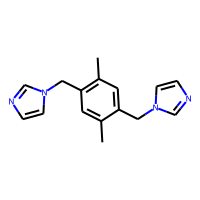
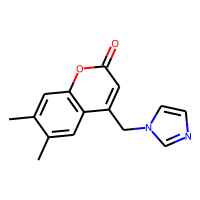
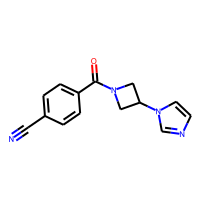
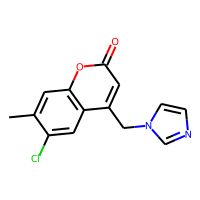
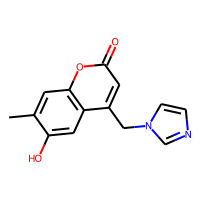
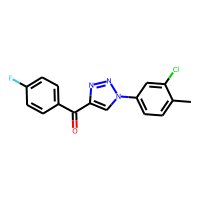
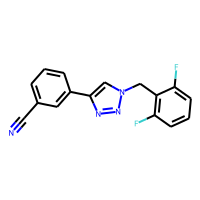
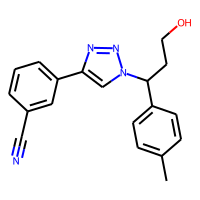
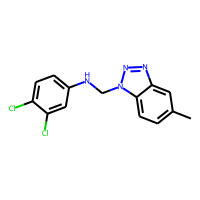
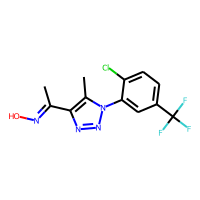

In [44]:
df_final

In [45]:
df_final.to_csv('/home/sliu/cyp_related_coding/CYP19_inhibitor_screening/old/df_final.csv', index=False)

## Cluster based on similarity

In [62]:
from tqdm.auto import tqdm
from rdkit.ML.Cluster import Butina
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
#meeded in cluter with butina function
def tanimoto_distance_matrix(fp_list):
    """
    Calculate distance matrix for fingerprint list.
    Copy pasted form Reference (see top of the notebook).
    """
    dissimilarity_matrix = []
    for i in tqdm(range(1, len(fp_list))):
        # Compare the current fingerprint against all the previous ones in the list
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([1 - x for x in similarities])
    return dissimilarity_matrix
#Group the results with tanimoto similarity by butina
#cluster with butina

def cluster_fingerprints(fp_list, cutoff=0.4):
    """
    Cluster fingerprints using Butina:
    given the input distance matrix cluster together all the
    molecules with a distance <= cutoff.
    e.g.: if cutoff == 0.3 the molecules with tanimoto >= 0.7
    will be clustered together.

    Returns a list of tuples where each tuple is a cluster
    and each value in the tuple correspond to the fingerprint
    index in the fingerprints list.

    Copy pasted from the Reference (see top of the notebook)
    """
    # Calculate Tanimoto distance matrix
    print("Computing distance matrix . . .")
    distance_matrix = tanimoto_distance_matrix(fp_list)
    # Cluster the data with the implemented Butina algorithm.
    print("Computing clusters . . .")
    clusters = Butina.ClusterData(distance_matrix, len(fp_list), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True) # Sort the list of clusters in descending order.
    print("Clusters computed!")
    return clusters

In [63]:
# reset index before clustering
df_final.reset_index(drop=True, inplace=True)

In [64]:
smiles = df_final['preprocessedSmiles']
# Get only the values from the series.
smiles_array = smiles.values
print("# of unique smiles:", len(smiles_array))


fingerprints_list = []
for smi in tqdm(smiles):
    mol = Chem.MolFromSmiles(smi) # get mol object
    fps = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048)
    fingerprints_list.append(fps)

# of unique smiles: 6182


100%|██████████| 6182/6182 [00:01<00:00, 6028.68it/s]


In [65]:
clusters = cluster_fingerprints(fingerprints_list)

Computing distance matrix . . .


100%|██████████| 6181/6181 [00:02<00:00, 2070.80it/s] 


Computing clusters . . .
Clusters computed!


In [66]:
len(clusters)

2863

In [67]:
for i in range(0, len(clusters)):
    for j in range(0, len(clusters[i])):
        ind = clusters[i][j]
        df_final.loc[ind, 'cluster_id'] = i


,preprocessedSmiles,MOLPORTID,model1_proba,rank,Rank,Model,Modelrank,model2_proba,model3_proba,model4_proba,...,closest_chembl_smiles,closest_chembl_activity,similairty_pubchem,closest_pubchem_smiles,closest_pubchem_activity,num_rotatable_bonds,mol,cluster_id_old,selection,cluster_id
0,Cc1cc(Cn2ccnc2)c(C)cc1Cn1ccnc1,MolPort-002-547-583,0.995,4.5,5,Model1,Model1_5,NaN,NaN,NaN,...,c1ccc(Oc2ccccc2Cn2ccnc2)cc1,1,0.36,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,4,,4607.0,NaN,890.0
1,Cc1cc2oc(=O)cc(Cn3ccnc3)c2cc1C,MolPort-002-644-642,0.985,16.0,15,Model1,Model1_15,NaN,NaN,NaN,...,COc1ccc2c(Cn3ccnc3)cc(=O)oc2c1,1,0.35,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,2,,224.0,1,160.0
2,N#Cc1ccc(C(=O)N2CC(n3ccnc3)C2)cc1,MolPort-044-359-245,0.979,24.0,24,Model1,Model1_24,NaN,NaN,NaN,...,N#Cc1ccc(C(c2ccc(C#N)cc2)n2ccnc2)cc1,1,0.283019,N#Cc1ccc(C(c2ccc(C#N)cc2)n2cncn2)cc1,1.0,2,,4606.0,NaN,2862.0
3,Cc1cc2oc(=O)cc(Cn3ccnc3)c2cc1Cl,MolPort-002-647-815,0.977,25.0,25,Model1,Model1_25,NaN,NaN,NaN,...,COc1ccc2c(Cn3ccnc3)cc(=O)oc2c1,1,0.307692,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,2,,224.0,1,160.0
4,Cc1cc2oc(=O)cc(Cn3ccnc3)c2cc1O,MolPort-002-531-039,0.975,26.5,27,Model1,Model1_27,NaN,NaN,NaN,...,COc1ccc2c(Cn3ccnc3)cc(=O)oc2c1,1,0.328125,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,2,,224.0,1,160.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6177,Cc1ccc(-n2cc(C(=O)c3ccc(F)cc3)nn2)cc1Cl,MolPort-002-852-088,NaN,1250.0,1242,Model4,Model4_1242,NaN,NaN,0.713,...,COc1cc2c(cc1OC)CN(S(=O)(=O)c1ccc(-n3cc(COc4ccc...,0,0.278689,Cc1cc(CC(=O)O)n(C)c1C(=O)c1ccc(Cl)cc1,0.0,3,,1079.0,1,1159.0
6178,N#Cc1cccc(-c2cn(Cc3c(F)cccc3F)nn2)c1,MolPort-027-870-718,NaN,1308.0,1302,Model4,Model4_1302,NaN,NaN,0.709,...,N#Cc1ccc(Cn2cc(-c3ccccc3)nn2)cc1,0,0.233766,CC(C)(O)c1cnn2c(-c3ccc(F)c(-c4c(F)cccc4C#N)c3)...,1.0,3,,1077.0,1,1158.0
6179,Cc1ccc(C(CCO)n2cc(-c3cccc(C#N)c3)nn2)cc1,MolPort-027-887-915,NaN,1326.0,1334,Model4,Model4_1334,NaN,NaN,0.708,...,N#Cc1ccc(C(c2ccc(C#N)cc2)n2cc(-c3ccccc3)nn2)cc1,0,0.241935,N#Cc1ccc(C(c2ccc(C#N)cc2)n2cncn2)cc1,1.0,5,,1076.0,0,1157.0
6180,Cc1ccc2c(c1)nnn2CNc1ccc(Cl)c(Cl)c1,MolPort-002-319-647,NaN,1372.5,1366,Model4,Model4_1366,NaN,NaN,0.705,...,Cc1ccc(-n2c(Cn3ccnc3)cc3ccc(Cl)cc32)cc1,1,0.220339,Cc1cc(Nc2ccccc2C(=O)O)ccc1Cl,0.0,3,,1075.0,1,1156.0

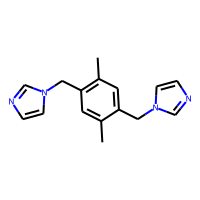
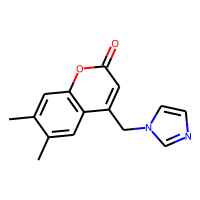
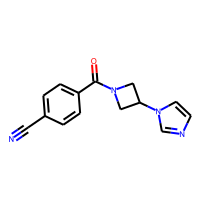
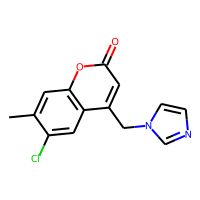
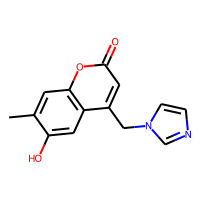
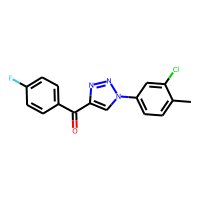
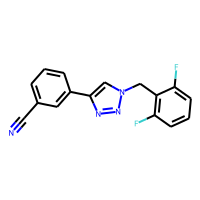
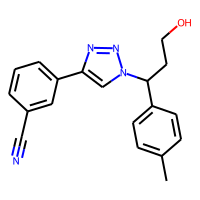
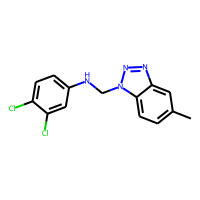
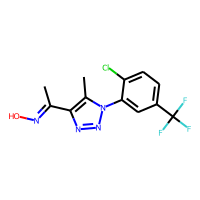

In [68]:
df_final

In [54]:
df_final.to_csv('df_final.csv',index=False)

,preprocessedSmiles,MOLPORTID,model1_proba,rank,Rank,Model,Modelrank,model2_proba,model3_proba,model4_proba,...,closest_chembl_smiles,closest_chembl_activity,similairty_pubchem,closest_pubchem_smiles,closest_pubchem_activity,num_rotatable_bonds,mol,cluster_id_old,selection,cluster_id
9,O=S(=O)(c1ccccc1C(F)(F)F)N1CC(Cn2ccnc2)C1,MolPort-047-408-074,0.964,42.5,43,Model1,Model1_43,NaN,NaN,NaN,...,O=S(=O)(c1ccc(F)c(F)c1F)N1CCCC(Cn2ccnc2)C1,1,0.290909,O=[PH](=O)(O)C(O)(Cn1ccnc1)[PH](=O)(=O)O,0.0,4,,425.0,1,380.0
34,O=c1cc(Cn2ccnc2)c2cc(O)c(-c3ccccc3)cc2o1,MolPort-002-528-878,0.949,106.5,105,Model1,Model1_105,NaN,NaN,NaN,...,O=c1cc(Cn2ccnc2)c2ccc(Nc3ccccc3)cc2o1,1,0.353846,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,3,,224.0,1,160.0
66,CSc1ccc2nc(N3CC(Cn4ccnc4)C3)sc2c1,MolPort-047-410-154,0.938,169.5,173,Model1,Model1_173,NaN,NaN,NaN,...,O=S(=O)(c1ccc2nsnc2c1)N1CCCC(Cn2ccnc2)C1,1,0.271186,O=[PH](=O)(O)C(O)(Cn1ccnc1)[PH](=O)(=O)O,0.0,4,,69.0,1,27.0
93,O=C(Cc1c(F)cccc1Cl)N1CCC(Cn2ccnc2)CC1,MolPort-009-743-166,NaN,137.0,136,Model2,Model2_136,0.922,NaN,NaN,...,O=S(=O)(c1ccc(F)c(Cl)c1)N1CCCC(Cn2ccnc2)C1,1,0.328571,Clc1ccc(C(Cn2ccnc2)OCc2c(Cl)cccc2Cl)c(Cl)c1,1.0,4,,875.0,1,337.0
2379,COc1ccc(C(=O)Nc2ccc(Cn3ccnc3)cc2)cc1OC,MolPort-002-025-171,NaN,676.0,685,Model2,Model2_685,0.854,NaN,NaN,...,O=C(c1ccccc1)c1ccc(Cn2ccnc2)cc1,1,0.390625,COc1ccc(C(=O)NCc2ccc(OCCN(C)C)cc2)cc1OC,0.0,6,,924.0,1,2.0
4965,CC(NC(=O)c1cc2cc(Cl)ccc2oc1=O)c1ccc(-n2ccnc2)cc1,MolPort-002-739-715,NaN,9994.5,9971,Model2,Model2_9971,0.738,NaN,NaN,...,Clc1ccc(C(c2cc3ccccc3o2)n2ccnc2)cc1,1,0.27027,CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1ccnc1,1.0,4,,1564.0,1,1425.0
4976,CC1(c2ccc(Cl)cc2Cl)OCC(Cn2cncn2)O1,MolPort-009-765-985,NaN,18.0,18,Model3,Model3_18,NaN,0.899,NaN,...,Clc1ccc(-c2[nH]c3cc(Cl)ccc3c2Cn2cncn2)cc1,1,0.631579,CCC1COC(Cn2cncn2)(c2ccc(Cl)cc2Cl)O1,1.0,3,,1557.0,1,1420.0
5729,COc1ccc(-c2cn3cccnc3n2)cc1NC(=O)c1ccc(Cl)cc1,MolPort-002-742-349,NaN,1319.0,1325,Model2,Model2_1325,0.829,NaN,NaN,...,Clc1ccc(-c2csc(-c3ncccn3)n2)cc1,0,0.333333,O=C(Nc1ccccc1-c1ccc(Cl)cc1)c1cccnc1Cl,0.0,4,,10.0,0,6.0
5751,COc1ccc(-c2cn3cccnc3n2)cc1NC(=O)Nc1ccc(F)cc1,MolPort-002-739-912,NaN,1653.0,1642,Model2,Model2_1642,0.820,NaN,NaN,...,O=C(Cn1ccnc1)Nc1ccccc1Oc1ccc(F)cc1,1,0.292683,COc1cc(OC)nc(NC(=O)NS(=O)(=O)c2ncccc2OCC(F)(F)...,0.0,4,,149.0,1,38.0
5788,O=C(Nc1cccc(-c2cn3cccnc3n2)c1)c1ccc(Cl)cc1Cl,MolPort-002-863-909,NaN,2258.5,2247,Model2,Model2_2247,0.807,NaN,NaN,...,Clc1cccc(-c2csc(-c3ncccn3)n2)c1,0,0.308824,O=C(Nc1ccccc1-c1ccc(Cl)cc1)c1cccnc1Cl,0.0,3,,23.0,1,25.0

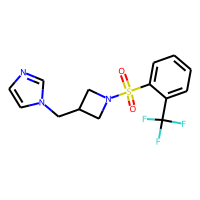
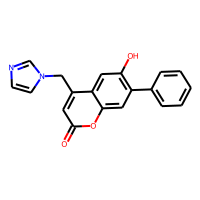
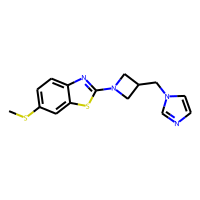
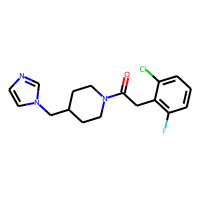
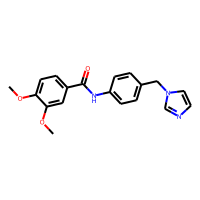
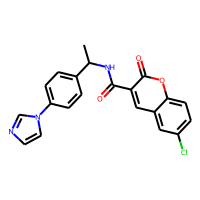
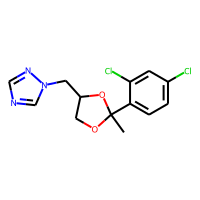
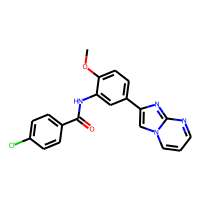
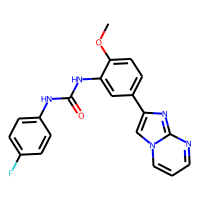
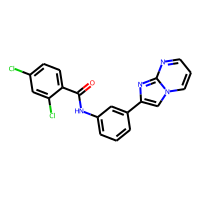

In [69]:
tested = pd.read_csv('/home/sliu/cyp_related_coding/RF_CYP19/chemical_space_compare/PCA_set/tested_smiles.csv')
survived = df_final[df_final['MOLPORTID'].isin(list((tested['MOLPORTID'])))]
survived

## analysis manually labeled result

,Structure of preprocessedSmiles [idcode],preprocessedSmiles,MOLPORTID,model1_proba,rank,Rank 2,Model,Modelrank,model2_proba,model3_proba,...,similairty_pubchem,Structure of closest_pubchem_smiles [idcode],closest_pubchem_smiles,closest_pubchem_activity,num_rotatable_bonds,mol,cluster_id_old,selection,cluster_id,Unnamed: 27
0,fcx`@DL|FOU`udTTRRVbrfTrbLRDjJZmWmjjjZfjjjVZ@@,CCC(=O)NCC(=O)N1CCC(c2nnc(Cn3ccnc3)n2C2CC2)CC1,MolPort-029-904-227,0.819,2605.5,2589,Model1,Model1_2589,NaN,NaN,...,0.272727,fj}p`@JArABSZsLkJIUoYJuU@pQTlP@@,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,7,,0.0,1,0.0,NaN
1,fmoX`@DN|ElpLrJJIIKQFISJHqHR`qKVZvjjjijjjef`@@,CC(C)OCC(=O)N1CCC(c2nnc(Cn3ccnc3)n2C2CC2)CC1,MolPort-027-869-648,0.806,3130.0,3150,Model1,Model1_3150,NaN,NaN,...,0.276316,fj}p`@JArABSZsLkJIUoYJuU@pQTlP@@,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,7,,0.0,1,0.0,NaN
2,fa{X`@DZM[KPLrJJIKYQJYQFIBeYtTmzuUUMUUTlt@@,O=C(CO)N1CCC(c2nnc(Cn3ccnc3)n2C2CC2)CC1,MolPort-027-881-832,0.852,1500.0,1502,Model1,Model1_1502,NaN,NaN,...,0.285714,fj}p`@JArABSZsLkJIUoYJuU@pQTlP@@,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,5,,0.0,1,0.0,NaN
3,figX`@LFlxoPHrJIQI[JISJHqJRg^SghvjjjZjjiYh@@,CCOC(=O)N1CCC(c2nnc(Cn3ccnc3)n2C2CC2)CC1,MolPort-027-871-160,0.786,4063.0,4064,Model1,Model1_4064,NaN,NaN,...,0.309859,fj}p`@JArABSZsLkJIUoYJuU@pQTlP@@,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,5,,0.0,1,0.0,NaN
4,fa{X`@BZM[KPHrJYQIYQJYQFIBeYtTmzuUUMUUTlt@@,O=C(O)CN1CCC(c2nnc(Cn3ccnc3)n2C2CC2)CC1,MolPort-027-886-203,0.852,1500.0,1519,Model1,Model1_1519,NaN,NaN,...,0.323529,fj}p`@JArABSZsLkJIUoYJuU@pQTlP@@,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,6,,0.0,1,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6177,figh@@@PlWnRJIPiSYQIYJIDiITT}GMP@UUUUJe@@@,Cc1cc(-n2cccn2)ccc1CN1CCC(Cn2ccnc2)CC1,MolPort-030-051-045,0.957,64.0,64,Model1,Model1_64,NaN,NaN,...,0.256757,fj}p`@JArABSZsLkJIUoYJuU@pQTlP@@,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,5,,4596.0,0,4152.0,NaN
6178,fa{H@@@XugIDeeDedhheEc`bmIKfkSUUTADMTP@@,CCn1ccc2c(CN3CCC(Cn4ccnc4)CC3)cccc21,MolPort-035-384-685,0.960,51.5,48,Model1,Model1_48,NaN,NaN,...,0.300000,fj}p`@JArABSZsLkJIUoYJuU@pQTlP@@,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,5,,4601.0,0,4157.0,NaN
6179,fagI@@DQRtFQQQQQQIVYIPjVeNmyNV}ZhJhHjZVb`@@,O=C(c1ccc2[nH]ccc2c1)N1C2CCC1CC(n1ccnc1)C2,MolPort-046-064-633,0.961,46.5,46,Model1,Model1_46,NaN,NaN,...,0.230769,fbm``@@`QdTRbbRRbTUUXpXiZ`hJJjb`@@,Cc1cc(C)cc(C(=O)OC2CC3CCC(C2)N3C)c1,0.0,2,,4602.0,0,4158.0,NaN
6180,ffch@@@XUDjRsK{Jzrtx{qZ}MUUUURm@@@,Cc1c(CN2CCC(Cn3ccnc3)CC2)cc(C#N)n1C,MolPort-047-512-283,0.966,37.5,38,Model1,Model1_38,NaN,NaN,...,0.267606,fj}p`@JArABSZsLkJIUoYJuU@pQTlP@@,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,4,,4603.0,0,4159.0,NaN

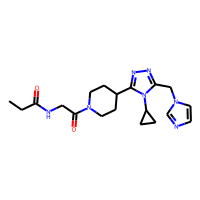
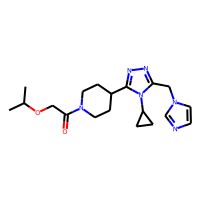
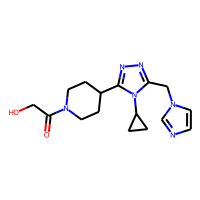
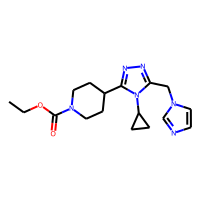
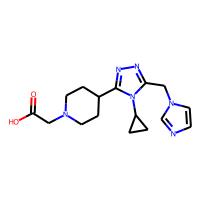
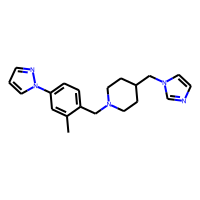
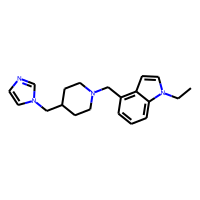
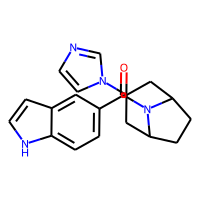
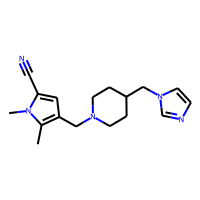
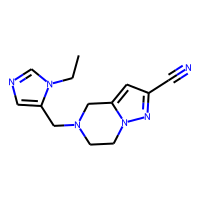

In [70]:
labeled = pd.read_csv('/home/sliu/cyp_related_coding/CYP19_inhibitor_screening/0815_df_final.txt', sep='\t')
labeled

,Structure of preprocessedSmiles [idcode],preprocessedSmiles,MOLPORTID,model1_proba,rank,Rank 2,Model,Modelrank,model2_proba,model3_proba,...,similairty_pubchem,Structure of closest_pubchem_smiles [idcode],closest_pubchem_smiles,closest_pubchem_activity,num_rotatable_bonds,mol,cluster_id_old,selection,cluster_id,Unnamed: 27
0,fcx`@DL|FOU`udTTRRVbrfTrbLRDjJZmWmjjjZfjjjVZ@@,CCC(=O)NCC(=O)N1CCC(c2nnc(Cn3ccnc3)n2C2CC2)CC1,MolPort-029-904-227,0.819,2605.5,2589,Model1,Model1_2589,NaN,NaN,...,0.272727,fj}p`@JArABSZsLkJIUoYJuU@pQTlP@@,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,7,,0.0,1,0.0,NaN
1,fmoX`@DN|ElpLrJJIIKQFISJHqHR`qKVZvjjjijjjef`@@,CC(C)OCC(=O)N1CCC(c2nnc(Cn3ccnc3)n2C2CC2)CC1,MolPort-027-869-648,0.806,3130.0,3150,Model1,Model1_3150,NaN,NaN,...,0.276316,fj}p`@JArABSZsLkJIUoYJuU@pQTlP@@,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,7,,0.0,1,0.0,NaN
2,fa{X`@DZM[KPLrJJIKYQJYQFIBeYtTmzuUUMUUTlt@@,O=C(CO)N1CCC(c2nnc(Cn3ccnc3)n2C2CC2)CC1,MolPort-027-881-832,0.852,1500.0,1502,Model1,Model1_1502,NaN,NaN,...,0.285714,fj}p`@JArABSZsLkJIUoYJuU@pQTlP@@,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,5,,0.0,1,0.0,NaN
3,figX`@LFlxoPHrJIQI[JISJHqJRg^SghvjjjZjjiYh@@,CCOC(=O)N1CCC(c2nnc(Cn3ccnc3)n2C2CC2)CC1,MolPort-027-871-160,0.786,4063.0,4064,Model1,Model1_4064,NaN,NaN,...,0.309859,fj}p`@JArABSZsLkJIUoYJuU@pQTlP@@,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,5,,0.0,1,0.0,NaN
4,fa{X`@BZM[KPHrJYQIYQJYQFIBeYtTmzuUUMUUTlt@@,O=C(O)CN1CCC(c2nnc(Cn3ccnc3)n2C2CC2)CC1,MolPort-027-886-203,0.852,1500.0,1519,Model1,Model1_1519,NaN,NaN,...,0.323529,fj}p`@JArABSZsLkJIUoYJuU@pQTlP@@,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,6,,0.0,1,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3409,fnsqb@LQkA@PAFRRFJIIKYIJYJlYuVkUAPQUTlP@@,COc1ccc(S(=O)(=O)N2CCC(Cn3ccnc3)CC2)cc1,MolPort-023-200-519,NaN,6.5,6,Model2,Model2_6,0.985,NaN,...,0.276923,fjmqa@LRmA@PA@`cIIBhhddmdeMNMYZ`dJJja@@,COc1ccc(S(=O)(=O)Nc2nnc(CC(C)C)s2)cc1,0.0,5,,4599.0,1,4155.0,NaN
3410,fj}I@@DJCdFQQQQIQKGJIRlhvRmTuTuUKT@@,Cc1c(C(=O)N2CCC(Cn3ccnc3)CC2)ccn1C,MolPort-044-687-991,0.960,51.5,50,Model1,Model1_50,NaN,NaN,...,0.338462,fj}p`@JArABSZsLkJIUoYJuU@pQTlP@@,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,3,,4600.0,1,4156.0,NaN
3411,ffcH`@INBTFldTtRRRbRReWAAbVm@PUURtiP@@,COc1cc(Cn2ccnc2)c(OC)cc1Cn1ccnc1,MolPort-000-726-782,0.971,28.5,29,Model1,Model1_29,NaN,NaN,...,0.320755,fi{Q@`CIDBHUDEbAqFQQQIQYYQQIQWLxgK^pDEUU@lADPhP@,Clc1ccc(COC(Cn2ccnc2)c2ccc(Cl)cc2Cl)c(Cl)c1,1.0,6,,4605.0,1,4160.0,NaN
3412,fluI@@DZBdBSLsj|jtDhpXmTDDUKq@@@,N#Cc1ccc(C(=O)N2CC(n3ccnc3)C2)cc1,MolPort-044-359-245,0.979,24.0,24,Model1,Model1_24,NaN,NaN,...,0.283019,ffch@@@RtFnQJIKJJJIIGIgOASg`@jhE@l`@@,N#Cc1ccc(C(c2ccc(C#N)cc2)n2cncn2)cc1,1.0,2,,4606.0,1,4161.0,NaN

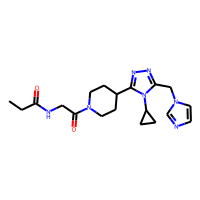
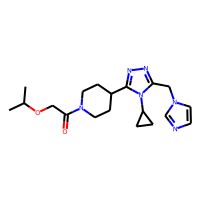
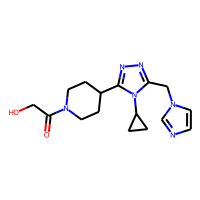
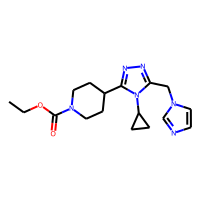
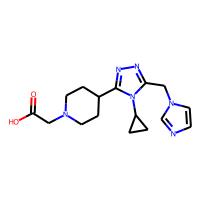
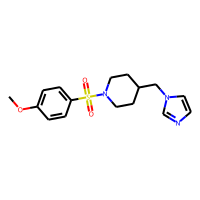
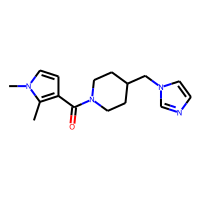
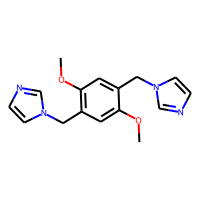
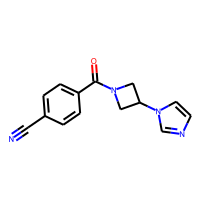
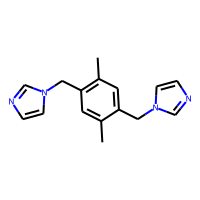

In [71]:
# filter the labeled data with selection = 1
selected = labeled[labeled['selection'] == '1']
selected

In [78]:
# assign new cluster_id to the manually labeled data from df_final['cluster_id'] based on MOLPORTID
selected['cluster_id_new'] = selected['MOLPORTID'].apply(lambda x: df_final[df_final['MOLPORTID'] == x]['cluster_id'].values[0])

,Structure of preprocessedSmiles [idcode],preprocessedSmiles,MOLPORTID,model1_proba,rank,Rank 2,Model,Modelrank,model2_proba,model3_proba,...,Structure of closest_pubchem_smiles [idcode],closest_pubchem_smiles,closest_pubchem_activity,num_rotatable_bonds,mol,cluster_id_old,selection,cluster_id,Unnamed: 27,cluster_id_new
0,fcx`@DL|FOU`udTTRRVbrfTrbLRDjJZmWmjjjZfjjjVZ@@,CCC(=O)NCC(=O)N1CCC(c2nnc(Cn3ccnc3)n2C2CC2)CC1,MolPort-029-904-227,0.819,2605.5,2589,Model1,Model1_2589,NaN,NaN,...,fj}p`@JArABSZsLkJIUoYJuU@pQTlP@@,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,7,,0.0,1,0.0,NaN,1.0
1,fmoX`@DN|ElpLrJJIIKQFISJHqHR`qKVZvjjjijjjef`@@,CC(C)OCC(=O)N1CCC(c2nnc(Cn3ccnc3)n2C2CC2)CC1,MolPort-027-869-648,0.806,3130.0,3150,Model1,Model1_3150,NaN,NaN,...,fj}p`@JArABSZsLkJIUoYJuU@pQTlP@@,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,7,,0.0,1,0.0,NaN,1.0
2,fa{X`@DZM[KPLrJJIKYQJYQFIBeYtTmzuUUMUUTlt@@,O=C(CO)N1CCC(c2nnc(Cn3ccnc3)n2C2CC2)CC1,MolPort-027-881-832,0.852,1500.0,1502,Model1,Model1_1502,NaN,NaN,...,fj}p`@JArABSZsLkJIUoYJuU@pQTlP@@,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,5,,0.0,1,0.0,NaN,1.0
3,figX`@LFlxoPHrJIQI[JISJHqJRg^SghvjjjZjjiYh@@,CCOC(=O)N1CCC(c2nnc(Cn3ccnc3)n2C2CC2)CC1,MolPort-027-871-160,0.786,4063.0,4064,Model1,Model1_4064,NaN,NaN,...,fj}p`@JArABSZsLkJIUoYJuU@pQTlP@@,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,5,,0.0,1,0.0,NaN,1.0
4,fa{X`@BZM[KPHrJYQIYQJYQFIBeYtTmzuUUMUUTlt@@,O=C(O)CN1CCC(c2nnc(Cn3ccnc3)n2C2CC2)CC1,MolPort-027-886-203,0.852,1500.0,1519,Model1,Model1_1519,NaN,NaN,...,fj}p`@JArABSZsLkJIUoYJuU@pQTlP@@,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,6,,0.0,1,0.0,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3409,fnsqb@LQkA@PAFRRFJIIKYIJYJlYuVkUAPQUTlP@@,COc1ccc(S(=O)(=O)N2CCC(Cn3ccnc3)CC2)cc1,MolPort-023-200-519,NaN,6.5,6,Model2,Model2_6,0.985,NaN,...,fjmqa@LRmA@PA@`cIIBhhddmdeMNMYZ`dJJja@@,COc1ccc(S(=O)(=O)Nc2nnc(CC(C)C)s2)cc1,0.0,5,,4599.0,1,4155.0,NaN,356.0
3410,fj}I@@DJCdFQQQQIQKGJIRlhvRmTuTuUKT@@,Cc1c(C(=O)N2CCC(Cn3ccnc3)CC2)ccn1C,MolPort-044-687-991,0.960,51.5,50,Model1,Model1_50,NaN,NaN,...,fj}p`@JArABSZsLkJIUoYJuU@pQTlP@@,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,3,,4600.0,1,4156.0,NaN,13.0
3411,ffcH`@INBTFldTtRRRbRReWAAbVm@PUURtiP@@,COc1cc(Cn2ccnc2)c(OC)cc1Cn1ccnc1,MolPort-000-726-782,0.971,28.5,29,Model1,Model1_29,NaN,NaN,...,fi{Q@`CIDBHUDEbAqFQQQIQYYQQIQWLxgK^pDEUU@lADPhP@,Clc1ccc(COC(Cn2ccnc2)c2ccc(Cl)cc2Cl)c(Cl)c1,1.0,6,,4605.0,1,4160.0,NaN,890.0
3412,fluI@@DZBdBSLsj|jtDhpXmTDDUKq@@@,N#Cc1ccc(C(=O)N2CC(n3ccnc3)C2)cc1,MolPort-044-359-245,0.979,24.0,24,Model1,Model1_24,NaN,NaN,...,ffch@@@RtFnQJIKJJJIIGIgOASg`@jhE@l`@@,N#Cc1ccc(C(c2ccc(C#N)cc2)n2cncn2)cc1,1.0,2,,4606.0,1,4161.0,NaN,2862.0

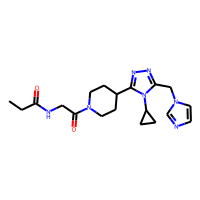
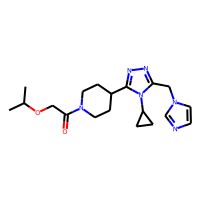
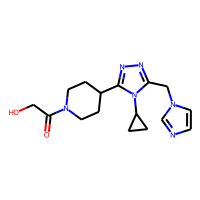
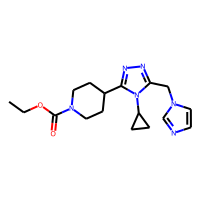
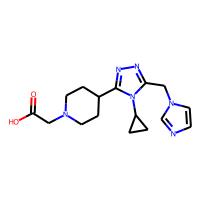
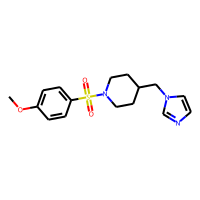
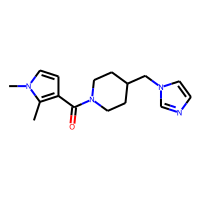
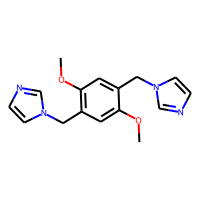
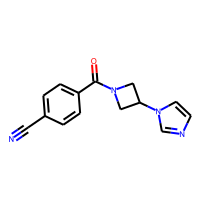
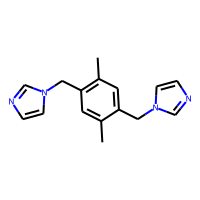

In [79]:
selected

In [80]:
# cluster ids of the selected data
selected['cluster_id_new'].unique()
len(selected['cluster_id_new'].unique())

1503

In [ ]:
selected

## charge filter (not used)

In [239]:
# add charge filter
# Define the function to calculate Gasteiger charges
def calculate_gasteiger_charges(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None  # Return None if the SMILES string is invalid

    mol = Chem.AddHs(mol)  # Add hydrogens to the molecule
    AllChem.ComputeGasteigerCharges(mol)  # Compute Gasteiger charges

    # Retrieve charges and return as a list
    charges = [float(atom.GetProp('_GasteigerCharge')) for atom in mol.GetAtoms()]
    return charges

# Define the function to calculate the total charge
def calculate_total_charge(charges):
    if charges is None:
        return None
    return sum(charges)

,preprocessedSmiles,MOLPORTID,model1_proba,rank,Rank,Model,Modelrank,model2_proba,model3_proba,model4_proba,...,closest_chembl_smiles,closest_chembl_activity,similairty_pubchem,closest_pubchem_smiles,closest_pubchem_activity,num_rotatable_bonds,mol,cluster_id,Gasteiger_Charges,Total_Charge
4878,CCn1c(/C=C/N(C)c2ccccc2)[n+](CC)c2cc(Cl)ccc21,MolPort-002-138-481,NaN,2896.5,2885,Model2,Model2_2885,0.796,NaN,NaN,...,CCn1ccc2cc(C(c3ccccc3)n3ccnc3)ccc21,1,0.245902,Cc1nc2ccccc2n1Cc1ccc(Cl)cc1,0.0,5,,1866.0,"[-0.026782905711662832, 0.08833776157777043, -...",1.0
5110,CN(C)C(=O)Oc1cccc(OCc2cn3ccccc3[n+]2C)c1,MolPort-046-864-323,NaN,6359.5,6294,Model2,Model2_6294,0.760,NaN,NaN,...,O=C(Cn1ccnc1)c1cccc(OCc2ccccc2)c1,0,0.33871,CCN(C)C(=O)Oc1cccc(C(C)N(C)C)c1,0.0,4,,1728.0,"[0.012214718843240293, -0.3139731221353057, 0....",1.0
5413,C[n+]1c(-c2ccccc2)c2cc(N)ccc2c2ccc(N)cc21,MolPort-003-928-298,NaN,29.0,29,Model3,Model3_29,NaN,0.859,NaN,...,Nc1ccc(-c2cccnc2)c(OCc2ccccc2)c1,1,0.666667,CC[n+]1c(-c2ccccc2)c2cc(N)ccc2c2ccc(N)cc21,1.0,1,,1554.0,"[0.13922953724098694, -0.19347841587704318, 0....",1.0
5419,C[n+]1cccc2cc(-c3ccc4c(ccc[n+]4C)c3)ccc21,MolPort-002-539-640,NaN,49.0,48,Model3,Model3_48,NaN,0.816,NaN,...,COC(=O)c1ccc2cc(-c3cccnc3)ccc2c1,0,0.233333,c1ccc2cc3c4ccccc4c4ccccc4c3cc2c1,1.0,1,,308.0,"[0.1385742190398924, -0.20101875397923766, 0.1...",2.0
5420,C[n+]1cccc2cc(-c3ccc4c(ccc[n+]4C)c3)ccc21,MolPort-002-152-262,NaN,49.0,49,Model3,Model3_49,NaN,0.816,NaN,...,COC(=O)c1ccc2cc(-c3cccnc3)ccc2c1,0,0.233333,c1ccc2cc3c4ccccc4c4ccccc4c3cc2c1,1.0,1,,308.0,"[0.1385742190398924, -0.20101875397923766, 0.1...",2.0
5421,C[n+]1cccc2cc(-c3ccc4c(ccc[n+]4C)c3)ccc21,MolPort-000-733-774,NaN,49.0,50,Model3,Model3_50,NaN,0.816,NaN,...,COC(=O)c1ccc2cc(-c3cccnc3)ccc2c1,0,0.233333,c1ccc2cc3c4ccccc4c4ccccc4c3cc2c1,1.0,1,,308.0,"[0.1385742190398924, -0.20101875397923766, 0.1...",2.0
5429,Cc1cc(C[n+]2ccccc2)c(C)cc1C[n+]1ccccc1,MolPort-046-843-180,NaN,67.0,67,Model3,Model3_67,NaN,0.794,NaN,...,Cc1cc(C)c(C)c(S(=O)(=O)NCc2cccc(CNS(=O)(=O)c3c...,0,0.322581,CCCCCCCCCCCCCCCC[n+]1ccccc1,1.0,4,,1546.0,"[-0.03924042952416426, -0.04107062590550157, -...",2.0
5449,C[n+]1ccc(C#Cc2ccccc2F)c2ccccc21,MolPort-047-118-854,NaN,106.5,106,Model3,Model3_106,NaN,0.750,NaN,...,COC(=O)c1ccc(N=Cc2cc(O)c3ccccc3c2O)cc1,0,0.22,Cc1cc(N)c2ccccc2[n+]1CCCCCCCCCC[n+]1c(C)cc(N)c...,1.0,0,,1529.0,"[0.13857590642507617, -0.20093351612534693, 0....",1.0
5492,Cc1cc(C)c(-n2cc[n+](-c3c(C)cc(C)cc3C)c2)c(C)c1,MolPort-003-937-195,NaN,169.5,171,Model3,Model3_171,NaN,0.707,NaN,...,Cc1ccc(-n2c(Cn3ccnc3)cc3ccc(C)cc32)cc1,1,0.2,Cc1cc(C)c(C(=O)P(=O)(C(=O)c2c(C)cc(C)cc2C)c2cc...,0.0,2,,1493.0,"[-0.03974934174456842, -0.05029299466566329, -...",1.0
5502,CSc1sc(SC)c(C[n+]2ccccc2)c1C[n+]1ccccc1,MolPort-002-131-893,NaN,184.5,186,Model3,Model3_186,NaN,0.703,NaN,...,CSc1nc2ccccn2c(=N)c1S(=O)(=O)c1ccccc1,1,0.285714,CCCCCCCCCCCCCCCC[n+]1ccccc1,1.0,6,,1485.0,"[-0.012830260365873874, -0.11833860463460387, ...",2.0

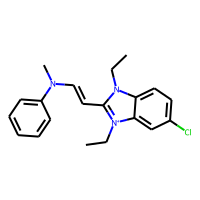
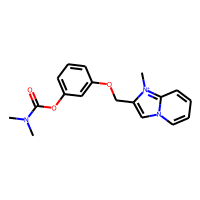
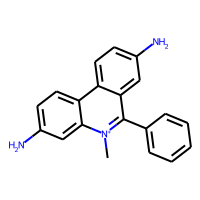
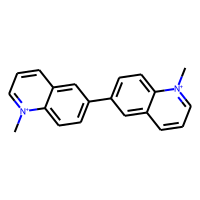
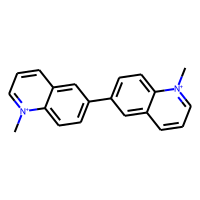
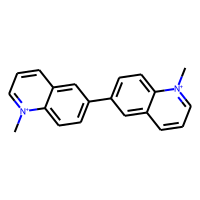
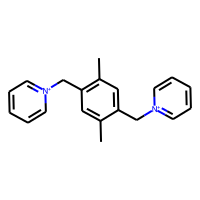
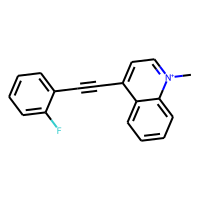
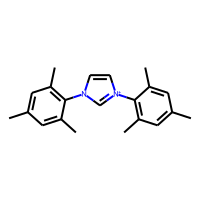
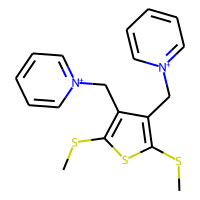
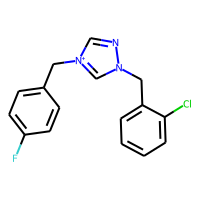
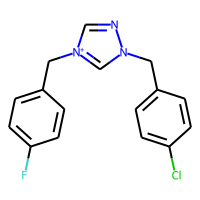
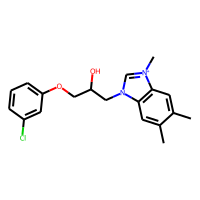
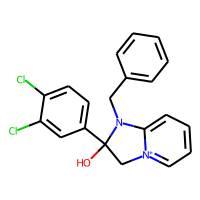
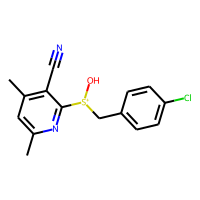

In [48]:
df = df_final
# Apply the function to calculate Gasteiger charges
df['Gasteiger_Charges'] = df['preprocessedSmiles'].apply(calculate_gasteiger_charges)

# Calculate the total charge for each molecule
df['Total_Charge'] = df['Gasteiger_Charges'].apply(calculate_total_charge)

# Filter out molecules with a positive charge
df_positive_charge = df[df['Total_Charge'] > 0.5]
df_positive_charge


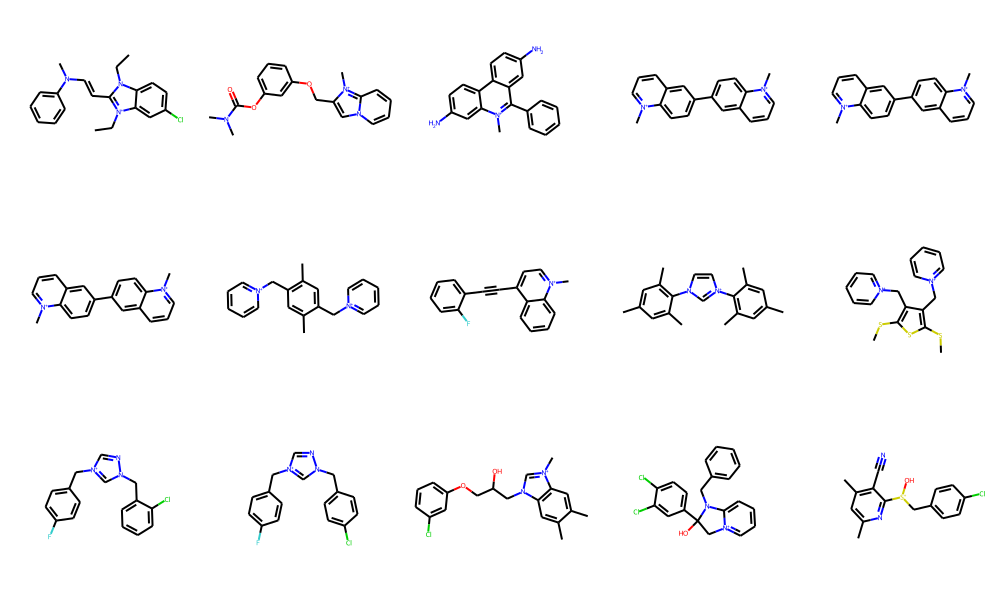

In [50]:
# list the mols in grids
# Define the function to list molecules in a grid
def list_molecules_in_grid(mols, mols_per_row=5):
    # Create a list to store the images
    images = []
    # Calculate the number of rows needed
    num_rows = len(mols) // mols_per_row + 1
    # Create a grid to store the images
    grid = Draw.MolsToGridImage(mols, molsPerRow=mols_per_row, subImgSize=(200, 200))
    # Convert the grid to an image and append it to the list
    images.append(grid)
    return images
df_positive_charge_mols = [Chem.MolFromSmiles(smi) for smi in df_positive_charge['preprocessedSmiles']]
images = list_molecules_in_grid(df_positive_charge_mols)
images[0]   # Display the grid image

In [508]:
df_prelabeled = pd.read_csv('hit_collection_checked.csv')
df_prelabeled

,Structure of preprocessedSmiles [idcode],preprocessedSmiles,MOLPORTID,model1_proba,rank,Rank 2,Model,Modelrank,model2_proba,model3_proba,...,SmilesFragFp 3,closest_chembl_smiles,closest_chembl_activity,similairty_pubchem,Structure of closest_pubchem_smiles [idcode],closest_pubchem_smiles,closest_pubchem_activity,num_rotatable_bonds,cluster_id,selection
0,fnsqA@FZCxDPhHrJIJZZIESJIJgMFjv@HjVf`@H@@,O=C(CSc1nccn1-c1cccc(Cl)c1)Nc1ccccc1,MolPort-003-031-527,NaN,888.0,886,Model2,Model2_886,0.843,NaN,...,NaN,O=C(Nc1ccc(Cl)cc1)OC(COc1ccccc1)Cn1ccnc1,1,0.292308,fleI`BHDihBEPeGYEMDhULeDdsdTmMUMP@H@@,O=C(Cn1ccnc1[N+](=O)[O-])NCc1ccccc1,0,5,0,0
1,fakpb@LDUIH@cIEDeEMBdhidlpWlu{SUSA@DAB@@@,COc1cccc(-n2ccnc2SCC(=O)Nc2ccccc2)c1,MolPort-003-031-336,NaN,4464.5,4491,Model2,Model2_4491,0.777,NaN,...,NaN,COc1ccc(C(=O)OC(COc2ccccc2)Cn2ccnc2)cc1,1,0.276923,fbu``@D@}dTRbbbRQattzpVh@H@bh@@@,Cc1ccccc1C(=O)Nc1cccc(OC(C)C)c1,0,6,0,0
2,fakpb@LDUIh@cIEDeEMBdhlmdpWdekSUSA@@AR@@@,COc1ccc(NC(=O)CSc2nccn2-c2ccccc2)cc1,MolPort-003-031-159,NaN,4164.0,4159,Model2,Model2_4159,0.780,NaN,...,NaN,COc1ccc(C(=O)OC(COc2ccccc2)Cn2ccnc2)cc1,1,0.298246,fmgQP@D]@jpYiL|kjjkJzpiUZu@AUUP@Tp@@@,CC(=O)Nc1ccc(OCCOCCOc2ccc(NC(C)=O)cc2)cc1,0,6,0,0
3,fakpb@LDUJh@cIEDeEMBdhldlpWde[SUSA@@DR@@@,COc1ccc(-n2ccnc2SCC(=O)Nc2ccccc2)cc1,MolPort-003-031-384,NaN,1862.5,1851,Model2,Model2_1851,0.815,NaN,...,NaN,COc1ccc(C(=O)OC(COc2ccccc2)Cn2ccnc2)cc1,1,0.285714,fbeQ`@DBAQNQQIIJJIIJitVjjB`hh@@,CCN(CC)CCNC(=O)COc1ccc(OC)cc1,0,6,0,0
4,fakpb@LDUJh@cIEDeEMBdhlmLpWde[SUSA@@DR@@@,COc1cccc(NC(=O)CSc2nccn2-c2ccccc2)c1,MolPort-003-031-189,NaN,2413.0,2387,Model2,Model2_2387,0.804,NaN,...,NaN,COc1ccc(C(=O)OC(COc2ccccc2)Cn2ccnc2)cc1,1,0.312500,fbu``@D@}dTRbbbRQattzpVh@H@bh@@@,Cc1ccccc1C(=O)Nc1cccc(OC(C)C)c1,0,6,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15664,ffcH`@INBTFldTtRRRbRReWAAbVm@PUURtiP@@,COc1cc(Cn2ccnc2)c(OC)cc1Cn1ccnc1,MolPort-000-726-782,0.971,28.5,29,Model1,Model1_29,NaN,NaN,...,NaN,c1ccc(Oc2ccccc2Cn2ccnc2)cc1,1,0.320755,fi{Q@`CIDBHUDEbAqFQQQIQYYQQIQWLxgK^pDEUU@lADPhP@,Clc1ccc(COC(Cn2ccnc2)c2ccc(Cl)cc2Cl)c(Cl)c1,1,6,10185,NaN
15665,fakIb@LN|VBF`BLddJbRRfRTVRbc^BVjuAAEUTkE@@@,CC(=O)N1CCc2cc(S(=O)(=O)NCCCn3ccnc3)ccc21,MolPort-019-797-165,0.971,28.5,28,Model1,Model1_28,NaN,NaN,...,NaN,O=S(=O)(NCCCn1ccnc1)c1ccc2c(c1)OCCO2,1,0.265625,fhqaR@EPQ`w`AFRRVIKISJBdm@ASS@@@,CC(=O)CC(=O)Nc1ccc(S(=O)(=O)O)cc1,0,6,10186,NaN
15666,fluI@@DZBdBSLsj|jtDhpXmTDDUKq@@@,N#Cc1ccc(C(=O)N2CC(n3ccnc3)C2)cc1,MolPort-044-359-245,0.979,24.0,24,Model1,Model1_24,NaN,NaN,...,NaN,N#Cc1ccc(C(c2ccc(C#N)cc2)n2ccnc2)cc1,1,0.283019,ffch@@@RtFnQJIKJJJIIGIgOASg`@jhE@l`@@,N#Cc1ccc(C(c2ccc(C#N)cc2)n2cncn2)cc1,1,2,10187,NaN
15667,fb}P`@MI@aIeYUUeVcEFCENViBBJjVJ@@,O=c1cc(Cn2ccnc2)c2cc3c(cc2o1)CCC3,MolPort-002-645-393,0.980,23.0,23,Model1,Model1_23,NaN,NaN,...,NaN,COc1ccc2c(Cn3ccnc3)cc(=O)oc2c1,1,0.272727,fj}p`@JArABSZsLkJIUoYJuU@pQTlP@@,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0,2,10188,NaN


,preprocessedSmiles,MOLPORTID,model1_proba,rank,Rank,Model,Modelrank,model2_proba,model3_proba,model4_proba,...,similairty_chembl,closest_chembl_smiles,closest_chembl_activity,similairty_pubchem,closest_pubchem_smiles,closest_pubchem_activity,num_rotatable_bonds,mol,cluster_id,selection
0,Cc1cc(Cn2ccnc2)c(C)cc1Cn1ccnc1,MolPort-002-547-583,0.995,4.5,5,Model1,Model1_5,NaN,NaN,NaN,...,0.45,c1ccc(Oc2ccccc2Cn2ccnc2)cc1,1,0.36,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,4,,4607.0,NaN
1,Cc1cc2oc(=O)cc(Cn3ccnc3)c2cc1C,MolPort-002-644-642,0.985,16.0,15,Model1,Model1_15,NaN,NaN,NaN,...,0.653061,COc1ccc2c(Cn3ccnc3)cc(=O)oc2c1,1,0.35,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,2,,224.0,NaN
2,N#Cc1ccc(C(=O)N2CC(n3ccnc3)C2)cc1,MolPort-044-359-245,0.979,24.0,24,Model1,Model1_24,NaN,NaN,NaN,...,0.387755,N#Cc1ccc(C(c2ccc(C#N)cc2)n2ccnc2)cc1,1,0.283019,N#Cc1ccc(C(c2ccc(C#N)cc2)n2cncn2)cc1,1.0,2,,4606.0,NaN
3,Cc1cc2oc(=O)cc(Cn3ccnc3)c2cc1Cl,MolPort-002-647-815,0.977,25.0,25,Model1,Model1_25,NaN,NaN,NaN,...,0.603774,COc1ccc2c(Cn3ccnc3)cc(=O)oc2c1,1,0.307692,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,2,,224.0,NaN
4,Cc1cc2oc(=O)cc(Cn3ccnc3)c2cc1O,MolPort-002-531-039,0.975,26.5,27,Model1,Model1_27,NaN,NaN,NaN,...,0.603774,COc1ccc2c(Cn3ccnc3)cc(=O)oc2c1,1,0.328125,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,2,,224.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6917,CC(C)CC(C(N)=O)n1cc(-c2cccc(Cl)c2Cl)nn1,MolPort-027-881-069,NaN,1250.0,1253,Model4,Model4_1253,NaN,NaN,0.713,...,0.267857,c1ccc(-c2cn(C(c3ccccc3)c3ccccc3)nn2)cc1,0,0.303571,Nc1nnc(-c2cccc(Cl)c2Cl)c(N)n1,0.0,5,,1078.0,NaN
6918,N#Cc1cccc(-c2cn(Cc3c(F)cccc3F)nn2)c1,MolPort-027-870-718,NaN,1308.0,1302,Model4,Model4_1302,NaN,NaN,0.709,...,0.530612,N#Cc1ccc(Cn2cc(-c3ccccc3)nn2)cc1,0,0.233766,CC(C)(O)c1cnn2c(-c3ccc(F)c(-c4c(F)cccc4C#N)c3)...,1.0,3,,1077.0,NaN
6919,Cc1ccc(C(CCO)n2cc(-c3cccc(C#N)c3)nn2)cc1,MolPort-027-887-915,NaN,1326.0,1334,Model4,Model4_1334,NaN,NaN,0.708,...,0.45614,N#Cc1ccc(C(c2ccc(C#N)cc2)n2cc(-c3ccccc3)nn2)cc1,0,0.241935,N#Cc1ccc(C(c2ccc(C#N)cc2)n2cncn2)cc1,1.0,5,,1076.0,NaN
6920,Cc1ccc2c(c1)nnn2CNc1ccc(Cl)c(Cl)c1,MolPort-002-319-647,NaN,1372.5,1366,Model4,Model4_1366,NaN,NaN,0.705,...,0.227273,Cc1ccc(-n2c(Cn3ccnc3)cc3ccc(Cl)cc32)cc1,1,0.220339,Cc1cc(Nc2ccccc2C(=O)O)ccc1Cl,0.0,3,,1075.0,NaN

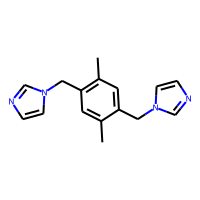
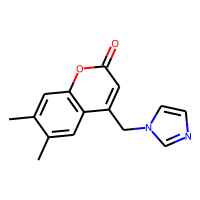
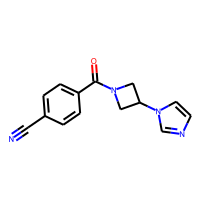
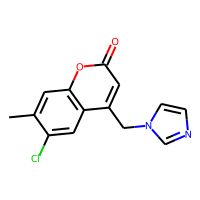
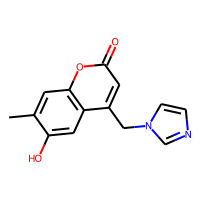
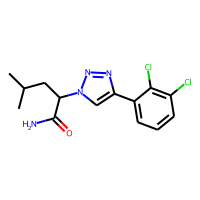
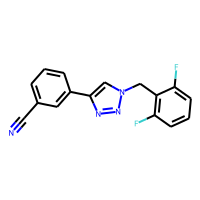
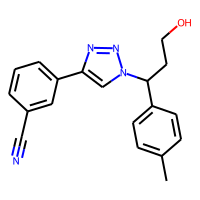
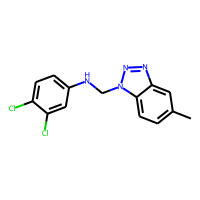
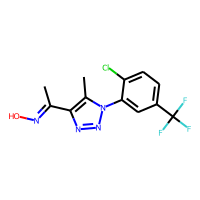

In [509]:
# add the label into the df_final (if available) from df_prelabeled
df_final = df_final.merge(df_prelabeled[['MOLPORTID', 'selection']], on='MOLPORTID', how='left')
df_final

,preprocessedSmiles,MOLPORTID,model1_proba,rank,Rank,Model,Modelrank,model2_proba,model3_proba,model4_proba,...,similairty_chembl,closest_chembl_smiles,closest_chembl_activity,similairty_pubchem,closest_pubchem_smiles,closest_pubchem_activity,num_rotatable_bonds,mol,cluster_id,selection
92,O=C(c1c(Cl)nc(Cl)c(Cl)c1Cl)n1ccnc1,MolPort-002-713-539,0.932,224.0,222,Model1,Model1_222,NaN,NaN,NaN,...,0.28,O=C(c1ccccc1)c1ccc(Cn2ccnc2)cc1,1,0.3125,Clc1nc(Cl)c(Cl)c(Cl)c1Cl,0.0,1,,4557.0,1
186,Cc1cc(F)c(F)c(C(=O)n2ccnc2)c1Cl,MolPort-002-705-159,0.916,373.5,376,Model1,Model1_376,NaN,NaN,NaN,...,0.268657,Cc1ccc(C(=O)NCCCn2ccnc2)cc1[N+](=O)[O-],1,0.322581,CCCN(CCOc1c(Cl)cc(Cl)cc1Cl)C(=O)n1ccnc1,1.0,1,,4503.0,0
226,CCC(Cn1ccnc1)NC1CSCCSC1,MolPort-045-958-039,0.907,475.5,467,Model1,Model1_467,NaN,NaN,NaN,...,0.3125,Cc1ncc(CNc2ccc(OCC(O)Cn3ccnc3)cc2)cn1,0,0.287879,Clc1ccc(C(Cn2ccnc2)OCc2ccsc2Cl)c(Cl)c1,1.0,5,,4468.0,0
227,Cc1cc(C)c(S(=O)(=O)n2ccnc2)cc1C,MolPort-035-673-053,0.907,475.5,468,Model1,Model1_468,NaN,NaN,NaN,...,0.478261,Cc1cc(C)c(S(=O)(=O)NCCCn2ccnc2)cc1C,1,0.236364,CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1ccnc1,1.0,2,,264.0,0
245,COc1ccc(S(=O)(=O)n2ccnc2)cc1C,MolPort-000-519-809,0.905,507.0,506,Model1,Model1_506,NaN,NaN,NaN,...,0.54717,COc1ccc(S(=O)(=O)NCCCn2ccnc2)cc1C,1,0.278689,CCN(CC)CCNC(=O)c1cc(S(C)(=O)=O)ccc1OC,0.0,3,,107.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6866,Cc1ccc(-c2cn3cccnc3n2)cc1NC(=O)CCc1ccccc1,MolPort-003-042-967,NaN,9040.5,9078,Model2,Model2_9078,0.743,NaN,NaN,...,0.253333,O=C(c1ccc(-c2ccccc2)cc1)c1cccc(Cn2ccnc2)c1,1,0.256757,O=C(Cn1ccnc1[N+](=O)[O-])NCc1ccccc1,0.0,5,,14.0,0
6869,COc1cc(-c2nc3cnccn3c2Nc2cccc(Cl)c2)ccc1O,MolPort-006-381-162,NaN,9228.5,9223,Model2,Model2_9223,0.742,NaN,NaN,...,0.3,COc1ccc2cc(-c3cccnc3)ccc2c1Cl,0,0.25,CCN(CC)Cc1cc(Nc2ccnc3cc(Cl)ccc23)ccc1O,0.0,4,,41.0,1
6886,COc1cc(-c2nc3cnccn3c2Nc2ccc(C)c(Cl)c2)ccc1O,MolPort-010-972-193,NaN,9629.0,9615,Model2,Model2_9615,0.740,NaN,NaN,...,0.277778,COc1ccc2cc(-c3cccnc3)ccc2c1Cl,0,0.257143,COc1cc(C(=S)N2CCOCC2)ccc1O,0.0,4,,41.0,1
6893,Cc1cc(C)cc(-n2ccn3cc(-c4ccc(Cl)cc4)nc3c2=O)c1,MolPort-010-752-638,NaN,9811.5,9870,Model2,Model2_9870,0.739,NaN,NaN,...,0.25,Clc1ccc(-c2csc(-c3ncccn3)n2)cc1,0,0.272727,CCCN(CCC)C(=O)Cc1c(-c2ccc(Cl)cc2)nc2ccc(Cl)cn12,0.0,2,,36.0,0

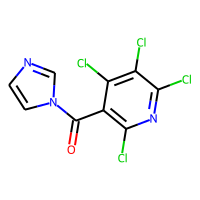
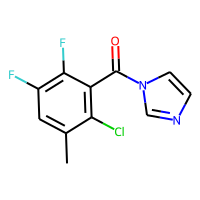
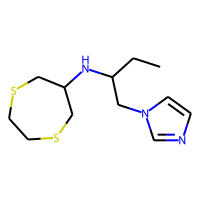
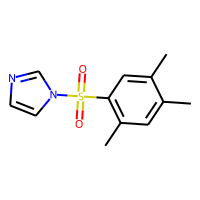
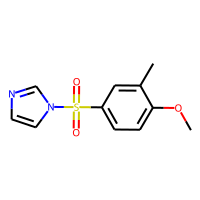
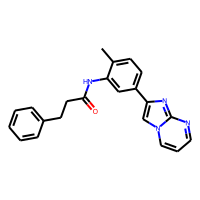
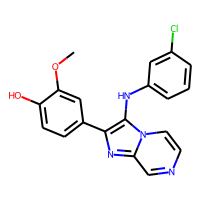
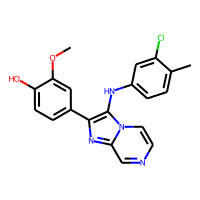
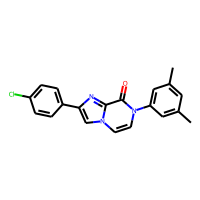
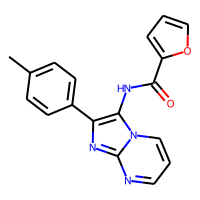

In [510]:
# list of rows that are labeled
labeled = df_final[~df_final['selection'].isnull()]
labeled

,preprocessedSmiles,MOLPORTID,model1_proba,rank,Rank,Model,Modelrank,model2_proba,model3_proba,model4_proba,...,similairty_chembl,closest_chembl_smiles,closest_chembl_activity,similairty_pubchem,closest_pubchem_smiles,closest_pubchem_activity,num_rotatable_bonds,mol,cluster_id,selection
10,O=S(=O)(c1ccccc1C(F)(F)F)N1CC(Cn2ccnc2)C1,MolPort-047-408-074,0.964,42.5,43,Model1,Model1_43,NaN,NaN,NaN,...,0.508197,O=S(=O)(c1ccc(F)c(F)c1F)N1CCCC(Cn2ccnc2)C1,1,0.290909,O=[PH](=O)(O)C(O)(Cn1ccnc1)[PH](=O)(=O)O,0.0,4,,425.0,NaN
35,O=c1cc(Cn2ccnc2)c2cc(O)c(-c3ccccc3)cc2o1,MolPort-002-528-878,0.949,106.5,105,Model1,Model1_105,NaN,NaN,NaN,...,0.648148,O=c1cc(Cn2ccnc2)c2ccc(Nc3ccccc3)cc2o1,1,0.353846,Cc1c(Cn2ccnc2)c2ccccc2n1CCC(=O)O,0.0,3,,224.0,NaN
69,CSc1ccc2nc(N3CC(Cn4ccnc4)C3)sc2c1,MolPort-047-410-154,0.938,169.5,173,Model1,Model1_173,NaN,NaN,NaN,...,0.356164,O=S(=O)(c1ccc2nsnc2c1)N1CCCC(Cn2ccnc2)C1,1,0.271186,O=[PH](=O)(O)C(O)(Cn1ccnc1)[PH](=O)(=O)O,0.0,4,,69.0,NaN
98,O=C(Cc1c(F)cccc1Cl)N1CCC(Cn2ccnc2)CC1,MolPort-009-743-166,NaN,137.0,136,Model2,Model2_136,0.922,NaN,NaN,...,0.449275,O=S(=O)(c1ccc(F)c(Cl)c1)N1CCCC(Cn2ccnc2)C1,1,0.328571,Clc1ccc(C(Cn2ccnc2)OCc2c(Cl)cccc2Cl)c(Cl)c1,1.0,4,,875.0,NaN
2547,COc1ccc(C(=O)Nc2ccc(Cn3ccnc3)cc2)cc1OC,MolPort-002-025-171,NaN,676.0,685,Model2,Model2_685,0.854,NaN,NaN,...,0.5,O=C(c1ccccc1)c1ccc(Cn2ccnc2)cc1,1,0.390625,COc1ccc(C(=O)NCc2ccc(OCCN(C)C)cc2)cc1OC,0.0,6,,924.0,NaN
5399,CC(NC(=O)c1cc2cc(Cl)ccc2oc1=O)c1ccc(-n2ccnc2)cc1,MolPort-002-739-715,NaN,9994.5,9971,Model2,Model2_9971,0.738,NaN,NaN,...,0.338028,Clc1ccc(C(c2cc3ccccc3o2)n2ccnc2)cc1,1,0.27027,CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1ccnc1,1.0,4,,1564.0,NaN
5410,CC1(c2ccc(Cl)cc2Cl)OCC(Cn2cncn2)O1,MolPort-009-765-985,NaN,18.0,18,Model3,Model3_18,NaN,0.899,NaN,...,0.338462,Clc1ccc(-c2[nH]c3cc(Cl)ccc3c2Cn2cncn2)cc1,1,0.631579,CCC1COC(Cn2cncn2)(c2ccc(Cl)cc2Cl)O1,1.0,3,,1557.0,NaN
6035,Nc1c(-c2ccc(F)cc2)cnn1-c1ccc(Cc2ccc(Cl)cc2Cl)nn1,MolPort-002-853-054,NaN,874.5,879,Model4,Model4_879,NaN,NaN,0.742,...,0.273973,Fc1ccc(-c2[nH]c3cc(Cl)ccc3c2Cn2cncn2)cc1,1,0.25,CC(C)(C)CC(C)(C)c1ccc(O)c(Cc2ccc(Cl)cc2Cl)c1,0.0,4,,1290.0,NaN
6452,COc1ccc(-c2cn3cccnc3n2)cc1NC(=O)c1ccc(Cl)cc1,MolPort-002-742-349,NaN,1319.0,1325,Model2,Model2_1325,0.829,NaN,NaN,...,0.272727,Clc1ccc(-c2csc(-c3ncccn3)n2)cc1,0,0.333333,O=C(Nc1ccccc1-c1ccc(Cl)cc1)c1cccnc1Cl,0.0,4,,10.0,0
6474,COc1ccc(-c2cn3cccnc3n2)cc1NC(=O)Nc1ccc(F)cc1,MolPort-002-739-912,NaN,1653.0,1642,Model2,Model2_1642,0.820,NaN,NaN,...,0.285714,O=C(Cn1ccnc1)Nc1ccccc1Oc1ccc(F)cc1,1,0.292683,COc1cc(OC)nc(NC(=O)NS(=O)(=O)c2ncccc2OCC(F)(F)...,0.0,4,,149.0,NaN

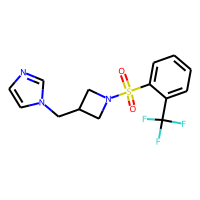
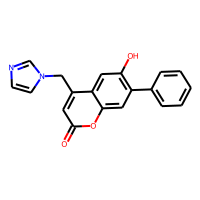
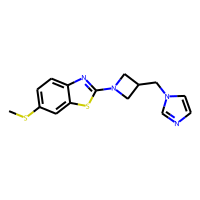
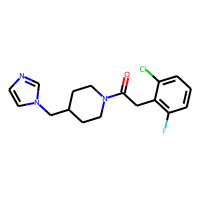
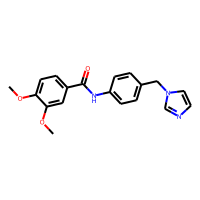
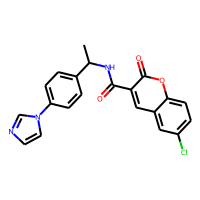
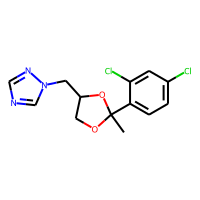
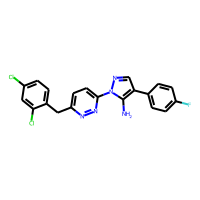
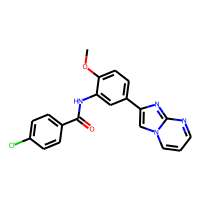
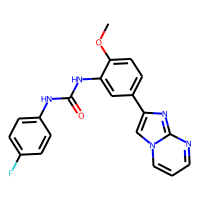
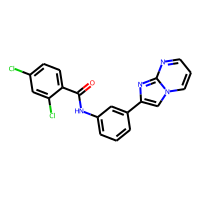

In [512]:
tested = pd.read_csv('/home/sliu/cyp_related_coding/RF_CYP19/chemical_space_compare/PCA_set/tested_smiles.csv')
survived = df_final[df_final['MOLPORTID'].isin(list((tested['MOLPORTID'])))]
survived